In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add the scripts folder to the system path so we can import time_series.py
import sys
import os

# for a folder that contain scripts for modularity 
sys.path.append(os.path.abspath('../scripts'))
sys.path.append(os.path.abspath('../src'))
import path

from data_loader import CSVData
from data_preprocessing import preprocess
from Overview_Analysis import overview
from Data_analysis import EDA
from db_connection import Db_Connection
from vizualization import visualize
from User_Engagement import engagement
from Experience_analytics import Experience
from Satisfaction_Analysis import UserSatisfaction

In [18]:
# Initialize the Db_Connection class
db = Db_Connection()
df = None
try:
    # Attempt to read data from the database
    # Call the read_data method for xdr_data
    df = db.read_data("xdr_data")
    # df = db.read_data()

except Exception as e:
    # Catch any exceptions and print an error message
    print(f"Error occurred: {e}")

finally:
    # Close the database connection (even if an error occurred)
    db.close_connection()

Database connection initialized successfully!
Database connection closed.


In [3]:
# Print the first few rows if data is available
top5_data = None
if not df.empty:
    top5_data = df.head()
else:
    print("No data found in the table.")
top5_data

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [68]:
folder_path = path.get_path()
file_load = CSVData(folder_path)
df = file_load.load_csv_file()
#df.head()

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [81]:
# Step 1: Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print("Missing Values and Percentage:")
print(pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage}))

# Step 2: Drop columns with excessive missing values 
threshold = 50  # Define your threshold
columns_to_drop = missing_percentage[missing_percentage > threshold].index
df = df.drop(columns=columns_to_drop)

print(f"\nDropped columns with more than {threshold}% missing values: {list(columns_to_drop)}")

# Step 3: Impute missing values
# For numerical columns: Replace missing values with the mean or median
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for column in numerical_columns:
    if df[column].isnull().sum() > 0:
        df[column].fillna(df[column].median(), inplace=True)  # Use mean() instead of median() if needed

# For categorical columns: Replace missing values with the mode
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if df[column].isnull().sum() > 0:
        df[column].fillna(df[column].mode()[0], inplace=True)

# Step 4: Verify if all missing values are handled
print("\nRemaining Missing Values (if any):")
print(df.isnull().sum())

# Step 5: Save the cleaned dataset (optional)
df.to_csv('cleaned_dataset.csv', index=False)  # Save to a new file


Missing Values and Percentage:
                                          Missing Values  Percentage (%)
Bearer Id                                              0               0
Start                                                  0               0
Start ms                                               0               0
End                                                    0               0
End ms                                                 0               0
Dur. (ms)                                              0               0
IMSI                                                   0               0
MSISDN/Number                                          0               0
IMEI                                                   0               0
Last Location Name                                     0               0
Avg RTT DL (ms)                                        0               0
Avg RTT UL (ms)                                        0               0
Avg Bearer TP DL (kb

In [43]:
# Create an instance of the class for description
file_path = path.get_path2()
load_descrip = CSVData(file_path)
description = load_descrip.load_description()
description.head(55)

,Fields,Description
0,bearer id,xDr session identifier
1,Dur. (ms),Total Duration of the xDR (in ms)
2,Start,Start time of the xDR (first frame timestamp)
3,Start ms,Milliseconds offset of start time for the xDR ...
4,End,End time of the xDR (last frame timestamp)
5,End ms,Milliseconds offset of end time of the xDR (la...
6,Dur. (s),Total Duration of the xDR (in s)
7,IMSI,International Mobile Subscriber Identity
8,MSISDN/Number,MS International PSTN/ISDN Number of mobile - ...
9,IMEI,International Mobile Equipment Identity


In [69]:
processing = preprocess(df)

# Numerical variables statistical summary
processing.nu_statistical_summary()

{'Numerical Summary':                                           count                 mean  \
 Bearer Id                                149010 10125542849473189888   
 Start ms                                 150000                  499   
 End ms                                   150000                  499   
 Dur. (ms)                                150000               104609   
 IMSI                                     149431      208201691804244   
 MSISDN/Number                            148935          41882818562   
 IMEI                                     149429       48474540644915   
 Avg RTT DL (ms)                          122172                  110   
 Avg RTT UL (ms)                          122189                   18   
 Avg Bearer TP DL (kbps)                  150000                13300   
 Avg Bearer TP UL (kbps)                  150000                 1770   
 TCP DL Retrans. Vol (Bytes)               61855             20809914   
 TCP UL Retrans. Vol (Bytes)  

In [7]:
# Categorical variables statistical summary
processing.ca_statistical_summary()

,unique_values,most_frequent,missing_values
Start,9997,4/26/2019 7:25,1
End,6403,4/25/2019 0:01,1
Last Location Name,45036,9.16E+15,1153
Handset Manufacturer,170,Apple,572
Handset Type,1396,Huawei B528S-23A,572


## Data Preprocessing

The dataset contains 55 columns, with fields such as timestamps, user identifiers, and data usage metrics. Here’s the general approach we’ll take for preprocessing:

   1.  Handle Missing Values: Identify and manage missing or null values.
   2.  Check Data Types: Ensure columns have the correct data types.
   3.  Duplicate Removal: Remove any duplicate rows.
   4.  Outlier Detection and Handling: Detect and handle anomalies in numerical fields.
   5.  Normalization/Standardization: Scale numerical features if needed.
   6.  Drop Irrelevant Columns: Remove columns that don't contribute to the analysis.

In [70]:
processing = preprocess(df)

In [71]:
# Identifying missing or null values in dataset.
missing_percentage = processing.missingvalues()


Missing Values and Percentage:
                                          Missing Values  Percentage (%)
Bearer Id                                            991               1
Start                                                  1               0
Start ms                                               1               0
End                                                    1               0
End ms                                                 1               0
Dur. (ms)                                              1               0
IMSI                                                 570               0
MSISDN/Number                                       1066               1
IMEI                                                 572               0
Last Location Name                                  1153               1
Avg RTT DL (ms)                                    27829              19
Avg RTT UL (ms)                                    27812              19
Avg Bearer TP DL (kb

In [72]:
# Step 1: Identify columns with missing values and their percentages
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

# Step 2: Drop columns with more than a specific threshold (e.g., 40% missing values)
threshold = 40  # Can be adjusted based on domain knowledge
columns_to_drop = missing_percentage[missing_percentage > threshold].index
data_cleaned = df.drop(columns=columns_to_drop, axis=1)
data_cleaned

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13100000000000000000,4/4/2019 12:01,770,4/25/2019 14:35,662,1823652,208201000000000,33664962239,35521200000000,9.16E+15,...,15854611,2501332,8198936,9656251,278082303,14344150,171744450,8814393,36749741,308879636
1,13100000000000000000,4/9/2019 13:04,235,4/25/2019 8:15,606,1365104,208202000000000,33681854413,35794000000000,L77566A,...,20247395,19111729,18338413,17227132,608750074,1170709,526904238,15055145,53800391,653384965
2,13100000000000000000,4/9/2019 17:42,1,4/25/2019 11:58,652,1361762,208200000000000,33760627129,35281500000000,D42335A,...,19725661,14699576,17587794,6163408,229584621,395630,410692588,4215763,27883638,279807335
3,13100000000000000000,4/10/2019 0:31,486,4/25/2019 7:36,171,1321509,208201000000000,33750343200,35356600000000,T21824A,...,21388122,15146643,13994646,1097942,799538153,10849722,749039933,12797283,43324218,846028530
4,13100000000000000000,4/12/2019 20:10,565,4/25/2019 10:40,954,1089009,208201000000000,33699795932,35407000000000,D88865A,...,15259380,18962873,17124581,415218,527707248,3529801,550709500,13910322,38542814,569138589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,7280000000000000000,4/29/2019 7:28,451,4/30/2019 6:02,214,81230,208202000000000,33650688697,35483100000000,D20434A,...,16191667,11763428,17883703,19678161,526609673,9197207,3264510,13487416,57628851,574175259
149997,7350000000000000000,4/29/2019 7:28,483,4/30/2019 10:41,187,97970,208202000000000,33663449963,35660500000000,D10223C,...,13877234,8288284,19350146,21293148,626893062,4735033,712180387,2457758,39135081,666648844
149998,13100000000000000000,4/29/2019 7:28,283,4/30/2019 10:46,810,98249,208202000000000,33621890103,35721200000000,T51102A,...,22660510,1855903,9963942,5065760,553539484,13394316,121100856,11314729,34912224,592786405
149999,13100000000000000000,4/29/2019 7:28,696,4/30/2019 10:40,327,97910,208202000000000,33619622058,86186200000000,L88342B,...,8817106,8305402,3322253,13172589,352536971,2529475,814713113,1406930,29626096,371895920


In [73]:
#Check for duplicate rows in the dataset and removing them.
processing.check_duplicates()

Number of duplicate rows: 0


(np.int64(0),
                   Bearer Id            Start  Start ms              End  \
 0      13100000000000000000   4/4/2019 12:01       770  4/25/2019 14:35   
 1      13100000000000000000   4/9/2019 13:04       235   4/25/2019 8:15   
 2      13100000000000000000   4/9/2019 17:42         1  4/25/2019 11:58   
 3      13100000000000000000   4/10/2019 0:31       486   4/25/2019 7:36   
 4      13100000000000000000  4/12/2019 20:10       565  4/25/2019 10:40   
 ...                     ...              ...       ...              ...   
 149996  7280000000000000000   4/29/2019 7:28       451   4/30/2019 6:02   
 149997  7350000000000000000   4/29/2019 7:28       483  4/30/2019 10:41   
 149998 13100000000000000000   4/29/2019 7:28       283  4/30/2019 10:46   
 149999 13100000000000000000   4/29/2019 7:28       696  4/30/2019 10:40   
 150000                  NaN              NaN       NaN              NaN   
 
         End ms  Dur. (ms)            IMSI  MSISDN/Number           IMEI

In [7]:
# Find rows where IMSI has the same value as another row (including the first occurrence)
duplicate_rows = df[df['IMSI'].duplicated(keep=False)]

# Sort the duplicate rows in descending order (based on IMSI or another column)
duplicate_rows_sorted = duplicate_rows.sort_values(by='IMSI', ascending=False)
duplicate_rows_sorted.head(10)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
928,1.304243e+19,4/24/2019 0:36,507.0,4/25/2019 0:36,507.0,86400.0,2.082099e+14,3.376355e+10,3.534681e+13,T73670B,...,14171064.0,17969140.0,17587261.0,13848108.0,627968339.0,15091927.0,541463155.0,13456536.0,61707527.0,667549401.0
100013,1.311448e+19,4/10/2019 3:25,731.0,4/29/2019 1:35,828.0,1634983.0,2.082099e+14,3.376355e+10,3.534681e+13,T73670B,...,14174006.0,9543474.0,11965711.0,5578206.0,324097722.0,175327.0,208645371.0,12252382.0,31723203.0,356910231.0
100012,1.311448e+19,4/9/2019 14:57,414.0,4/29/2019 1:34,128.0,1679813.0,2.082099e+14,3.376355e+10,3.534681e+13,T73670B,...,7725935.0,6547902.0,15286906.0,4138800.0,576169362.0,4962473.0,465550776.0,9629071.0,29396179.0,616799784.0
35084,1.304243e+19,4/25/2019 0:37,736.0,4/26/2019 0:37,673.0,86399.0,2.082099e+14,3.376355e+10,3.534681e+13,T73670B,...,2608005.0,21288360.0,3635842.0,21626694.0,405336480.0,9423438.0,473194680.0,6111494.0,61338162.0,417888492.0
73962,1.304243e+19,4/26/2019 8:59,104.0,4/27/2019 9:03,937.0,86663.0,2.082099e+14,3.376028e+10,3.561421e+13,L74520B,...,2201704.0,20237521.0,6923567.0,13389347.0,320292878.0,9122478.0,607034935.0,5053533.0,52785286.0,344925314.0
126130,1.311448e+19,4/27/2019 6:34,876.0,4/30/2019 9:03,491.0,268168.0,2.082099e+14,3.376028e+10,3.561421e+13,L74520B,...,19475763.0,3528408.0,5634954.0,18093545.0,606097758.0,6292260.0,275430829.0,11456898.0,41073898.0,635963320.0
125496,1.311448e+19,4/26/2019 8:27,725.0,4/30/2019 9:03,491.0,347776.0,2.082099e+14,3.376028e+10,3.561421e+13,D74520B,...,22419655.0,17706491.0,2609118.0,16525840.0,137927491.0,13113177.0,7318020.0,6129257.0,55953452.0,170587102.0
74818,1.311448e+19,4/26/2019 9:08,610.0,4/27/2019 17:34,445.0,116747.0,2.082099e+14,3.365079e+10,8.601480e+13,T11002B,...,9955581.0,20590753.0,507077.0,14615308.0,149996706.0,8658828.0,404325160.0,7309876.0,53725758.0,170371658.0
47434,1.311448e+19,4/25/2019 7:26,740.0,4/26/2019 9:02,392.0,92194.0,2.082099e+14,3.365079e+10,8.601480e+13,L53511B,...,11970181.0,18580955.0,3208365.0,1652746.0,454323036.0,13543988.0,819566172.0,11085838.0,47792313.0,480954634.0
47432,1.304243e+19,4/25/2019 7:26,524.0,4/26/2019 7:26,487.0,86399.0,2.082099e+14,3.365079e+10,8.601480e+13,D53511B,...,20916267.0,2629566.0,7121992.0,2655156.0,128060029.0,12311376.0,797628131.0,5095590.0,26948253.0,166949095.0


In [3]:
missingvalues = EDA(df)

From the above figure to replace missing values in the MSISDN/Number and IMEI columns, I use the groupby('IMSI') method followed by transform(lambda x: x.fillna(method='pad')). This fills the NaN values within each group of the same IMSI with the previous available value from the same group. 

In [4]:
missingvalues.fill_null_by_imsi_group()

Filling missing 'MSISDN/Number' and 'IMEI' by IMSI group...


c:\Users\Specter\Downloads\Tenx_cademy\Tellcom_project_w3\scripts\Data_analysis.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df['MSISDN/Number'] = self.df.groupby('IMSI')['MSISDN/Number'].transform(lambda x: x.fillna(method='pad'))
c:\Users\Specter\Downloads\Tenx_cademy\Tellcom_project_w3\scripts\Data_analysis.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df['IMEI'] = self.df.groupby('IMSI')['IMEI'].transform(lambda x: x.fillna(method='pad'))


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,1.585461e+07,2.501332e+06,8.198936e+06,9.656251e+06,2.780823e+08,1.434415e+07,1.717444e+08,8.814393e+06,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,2.024740e+07,1.911173e+07,1.833841e+07,1.722713e+07,6.087501e+08,1.170709e+06,5.269042e+08,1.505514e+07,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,1.972566e+07,1.469958e+07,1.758779e+07,6.163408e+06,2.295846e+08,3.956300e+05,4.106926e+08,4.215763e+06,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,2.138812e+07,1.514664e+07,1.399465e+07,1.097942e+06,7.995382e+08,1.084972e+07,7.490399e+08,1.279728e+07,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,1.525938e+07,1.896287e+07,1.712458e+07,4.152180e+05,5.277072e+08,3.529801e+06,5.507095e+08,1.391032e+07,38542814.0,569138589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,7.277826e+18,4/29/2019 7:28,451.0,4/30/2019 6:02,214.0,81230.0,2.082022e+14,3.365069e+10,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,5.266097e+08,9.197207e+06,3.264510e+06,1.348742e+07,57628851.0,574175259.0
149997,7.349883e+18,4/29/2019 7:28,483.0,4/30/2019 10:41,187.0,97970.0,2.082019e+14,3.366345e+10,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,6.268931e+08,4.735033e+06,7.121804e+08,2.457758e+06,39135081.0,666648844.0
149998,1.311448e+19,4/29/2019 7:28,283.0,4/30/2019 10:46,810.0,98249.0,2.082017e+14,3.362189e+10,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,5.535395e+08,1.339432e+07,1.211009e+08,1.131473e+07,34912224.0,592786405.0
149999,1.311448e+19,4/29/2019 7:28,696.0,4/30/2019 10:40,327.0,97910.0,2.082021e+14,3.361962e+10,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,3.525370e+08,2.529475e+06,8.147131e+08,1.406930e+06,29626096.0,371895920.0


In [5]:
# Replace missing values in 'MSISDN/Number' with the mode of the column
mode_value = df['MSISDN/Number'].mode()[0]
df['MSISDN/Number'] = df['MSISDN/Number'].fillna(mode_value)

In [6]:
null_columns_greater_than_0 =  df.columns[(df.isnull().sum() > 0)]
df[null_columns_greater_than_0].isna().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)                             754
UL TP < 10 Kbps (%)            

In [7]:
df[null_columns_greater_than_0].describe().T

,count,mean,std,min,25%,50%,75%,max
Bearer Id,149010.0,1.013887e+19,2.893173e+18,6.917538e+18,7.349883e+18,7.349883e+18,1.304243e+19,1.318654e+19
Start ms,150000.0,4.991882e+02,2.886118e+02,0.000000e+00,2.500000e+02,4.990000e+02,7.490000e+02,9.990000e+02
End ms,150000.0,4.988009e+02,2.880977e+02,0.000000e+00,2.510000e+02,5.000000e+02,7.500000e+02,9.990000e+02
Dur. (ms),150000.0,1.046086e+05,8.103762e+04,7.142000e+03,5.744050e+04,8.639900e+04,1.324302e+05,1.859336e+06
IMSI,149431.0,2.082016e+14,2.148809e+10,2.040471e+14,2.082014e+14,2.082015e+14,2.082018e+14,2.140743e+14
IMEI,149429.0,4.847455e+13,2.241637e+13,4.400152e+11,3.546071e+13,3.572201e+13,8.611970e+13,9.900120e+13
Avg RTT DL (ms),122172.0,1.097957e+02,6.197827e+02,0.000000e+00,3.200000e+01,4.500000e+01,7.000000e+01,9.692300e+04
Avg RTT UL (ms),122189.0,1.766288e+01,8.479352e+01,0.000000e+00,2.000000e+00,5.000000e+00,1.500000e+01,7.120000e+03
Avg Bearer TP DL (kbps),150000.0,1.330005e+04,2.397188e+04,0.000000e+00,4.300000e+01,6.300000e+01,1.971075e+04,3.781600e+05
Avg Bearer TP UL (kbps),150000.0,1.770429e+03,4.625356e+03,0.000000e+00,4.700000e+01,6.300000e+01,1.120000e+03,5.861300e+04


# The Distributions of Numeric Missing Values

In [8]:
# Identify columns with missing values
null_columns_greater_than_0 = df.columns[df.isnull().any()]

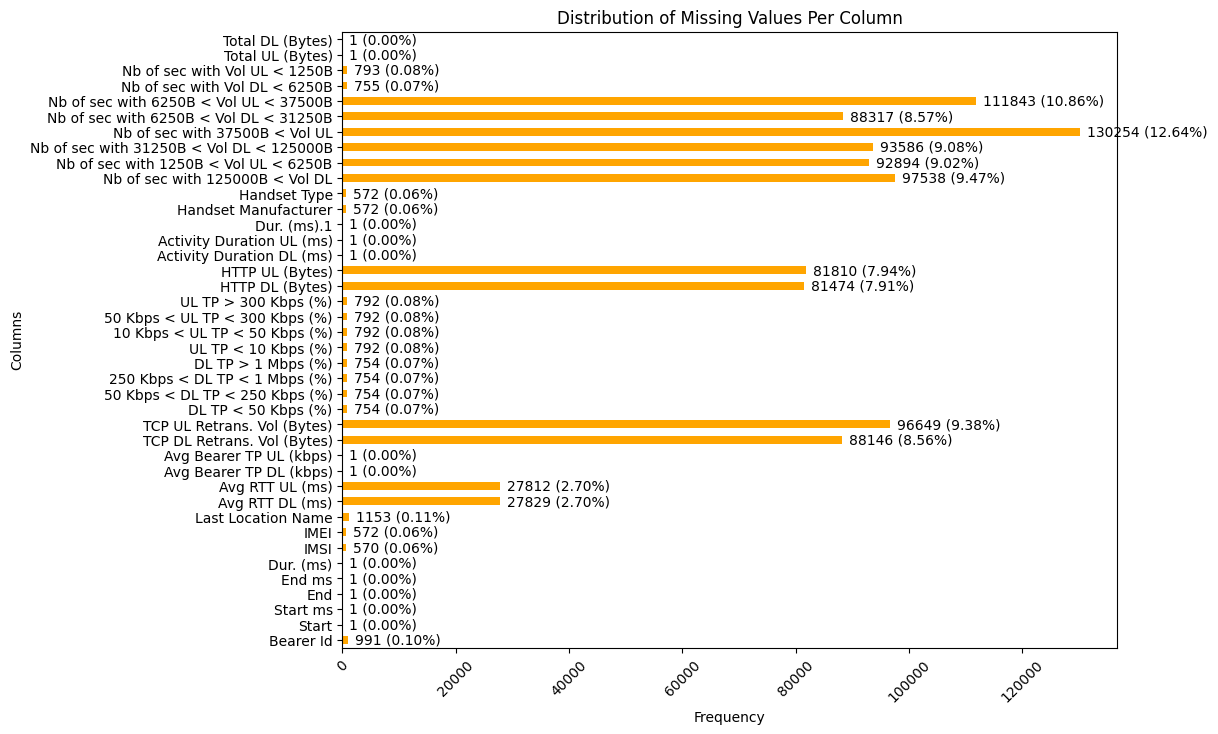

In [9]:
# Initialize the Plot class
plot_distr = visualize(df)
# Call the method to plot the distribution of missing values
plot_distr.distribution_of_missing_values(null_columns_greater_than_0)

Skewness for columns 1 to 12:
Bearer Id                        0.026666
Start ms                         0.000968
End ms                          -0.001163
Dur. (ms)                        3.952609
IMSI                            41.045956
MSISDN/Number                  333.342444
IMEI                             1.071470
Avg RTT DL (ms)                 62.907828
Avg RTT UL (ms)                 28.457415
Avg Bearer TP DL (kbps)          2.589437
Avg Bearer TP UL (kbps)          4.503413
TCP DL Retrans. Vol (Bytes)     15.951809
dtype: float64


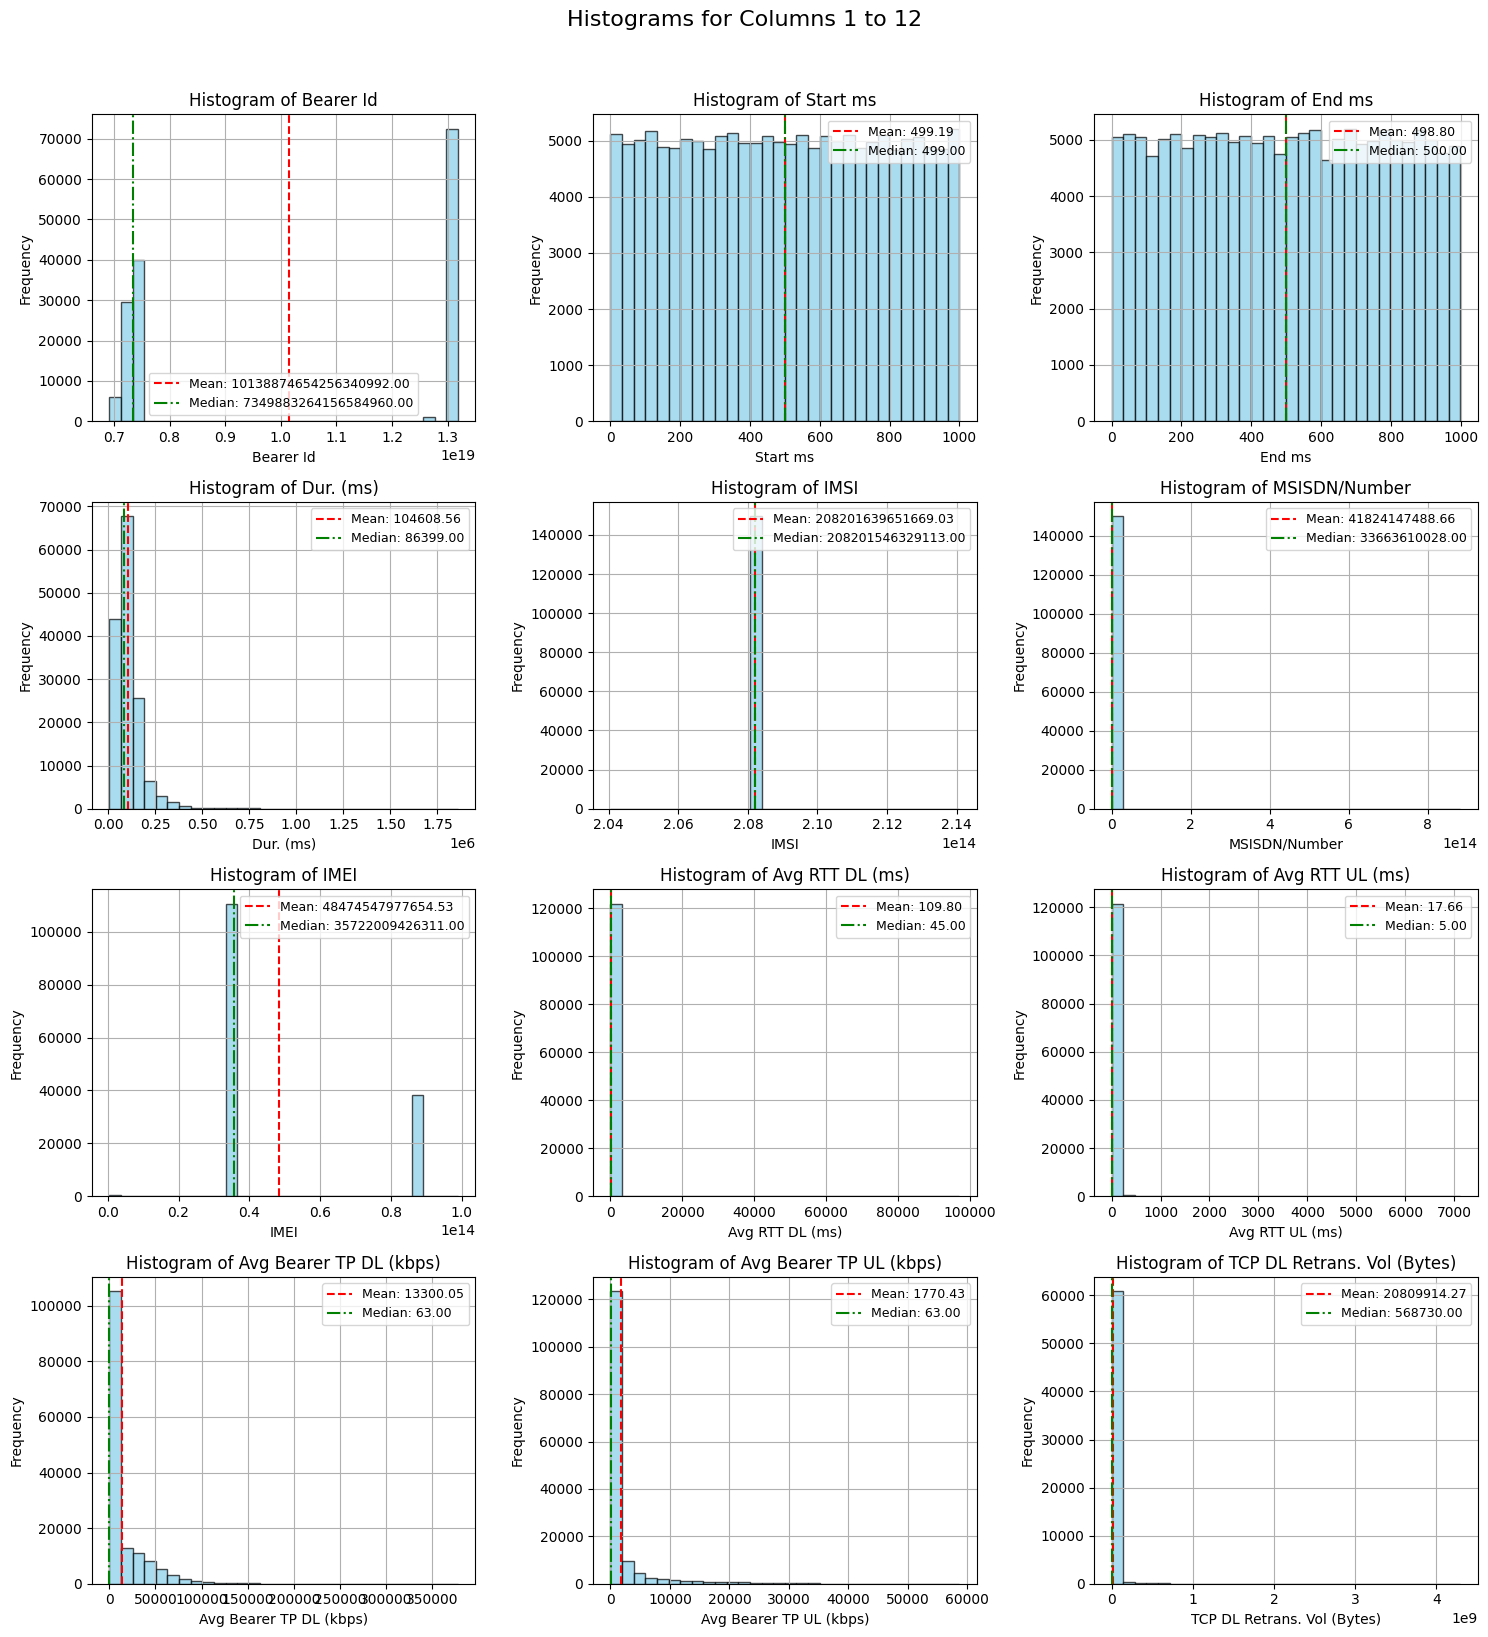

Skewness for columns 13 to 24:
TCP UL Retrans. Vol (Bytes)       84.113393
DL TP < 50 Kbps (%)               -2.297803
50 Kbps < DL TP < 250 Kbps (%)     3.271453
250 Kbps < DL TP < 1 Mbps (%)      4.566158
DL TP > 1 Mbps (%)                 5.370351
UL TP < 10 Kbps (%)               -8.985016
10 Kbps < UL TP < 50 Kbps (%)     10.943888
50 Kbps < UL TP < 300 Kbps (%)    21.878495
UL TP > 300 Kbps (%)              36.174053
HTTP DL (Bytes)                   38.944710
HTTP UL (Bytes)                   32.474970
Activity Duration DL (ms)          5.872256
dtype: float64


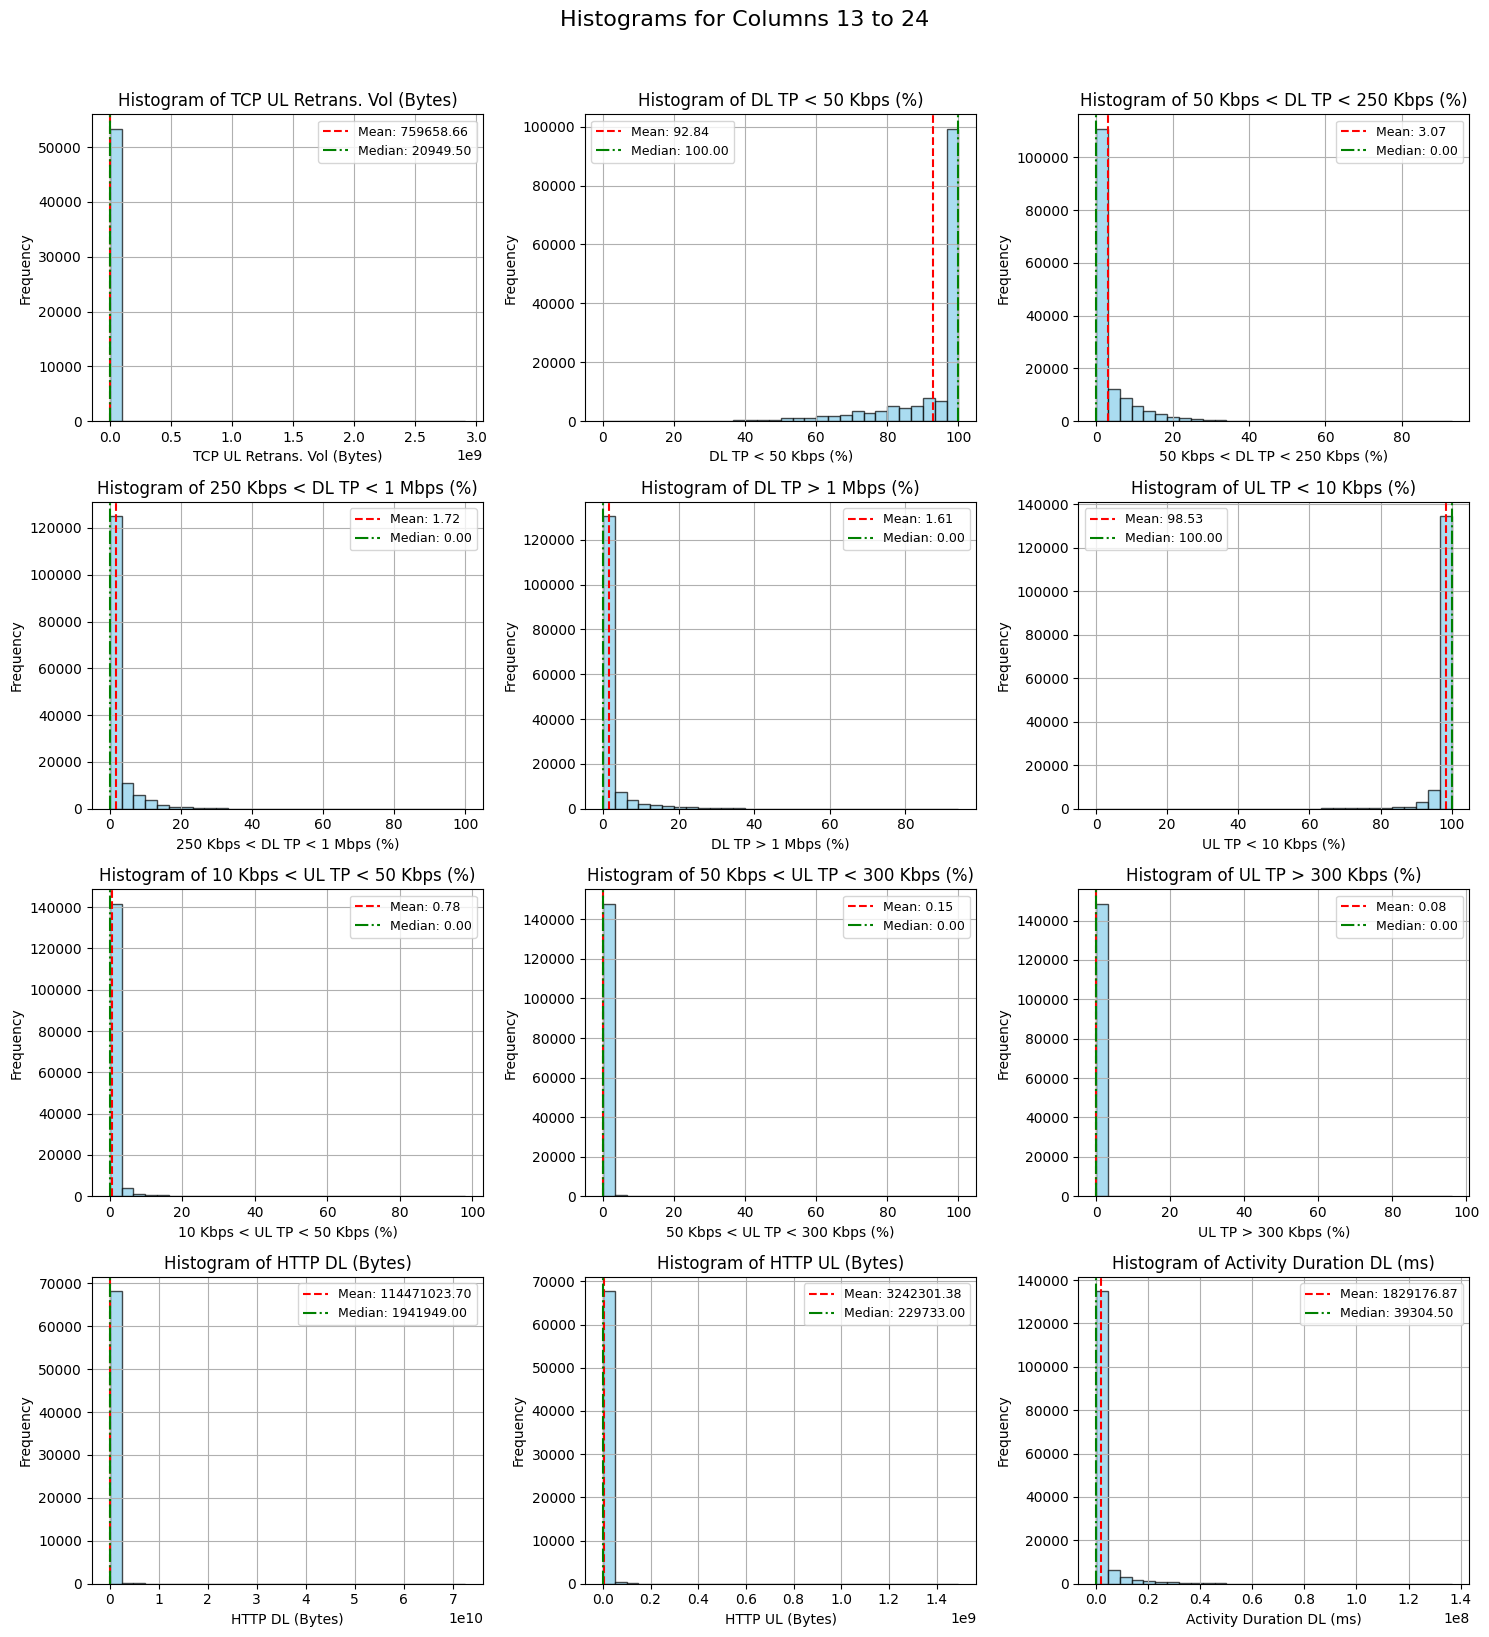

Skewness for columns 25 to 36:
Activity Duration UL (ms)                    7.382557
Dur. (ms).1                                  3.952609
Nb of sec with 125000B < Vol DL              6.592502
Nb of sec with 1250B < Vol UL < 6250B       22.035745
Nb of sec with 31250B < Vol DL < 125000B     6.610541
Nb of sec with 37500B < Vol UL              21.560028
Nb of sec with 6250B < Vol DL < 31250B       6.896050
Nb of sec with 6250B < Vol UL < 37500B      19.642752
Nb of sec with Vol DL < 6250B                9.042166
Nb of sec with Vol UL < 1250B                7.495176
Social Media DL (Bytes)                     -0.002136
Social Media UL (Bytes)                     -0.000359
dtype: float64


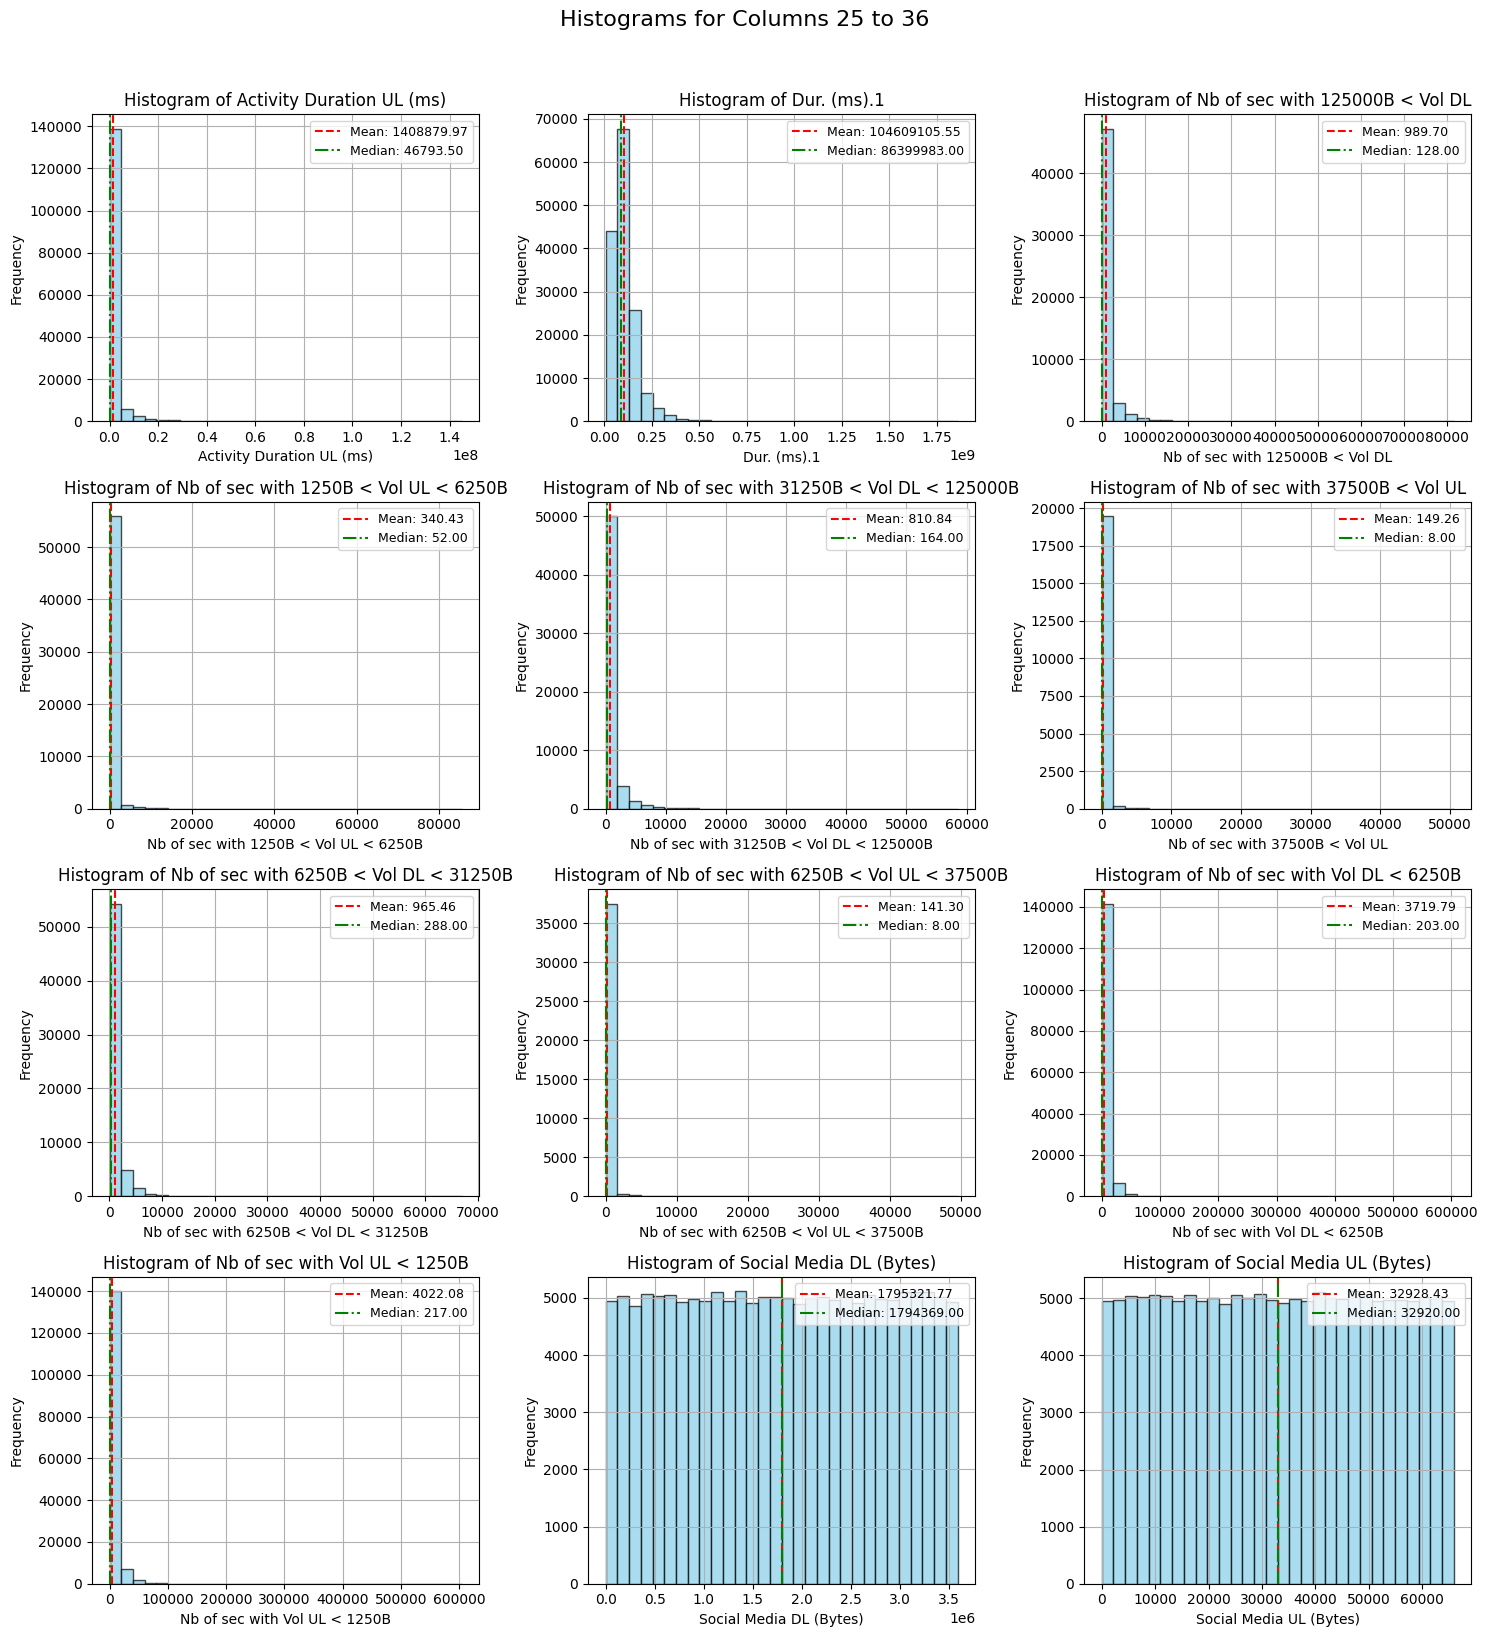

Skewness for columns 37 to 48:
Google DL (Bytes)    -0.008092
Google UL (Bytes)     0.002216
Email DL (Bytes)     -0.002463
Email UL (Bytes)      0.007358
Youtube DL (Bytes)    0.000231
Youtube UL (Bytes)   -0.001142
Netflix DL (Bytes)   -0.002442
Netflix UL (Bytes)   -0.000113
Gaming DL (Bytes)    -0.003460
Gaming UL (Bytes)    -0.001840
Other DL (Bytes)      0.001400
Other UL (Bytes)      0.001392
dtype: float64


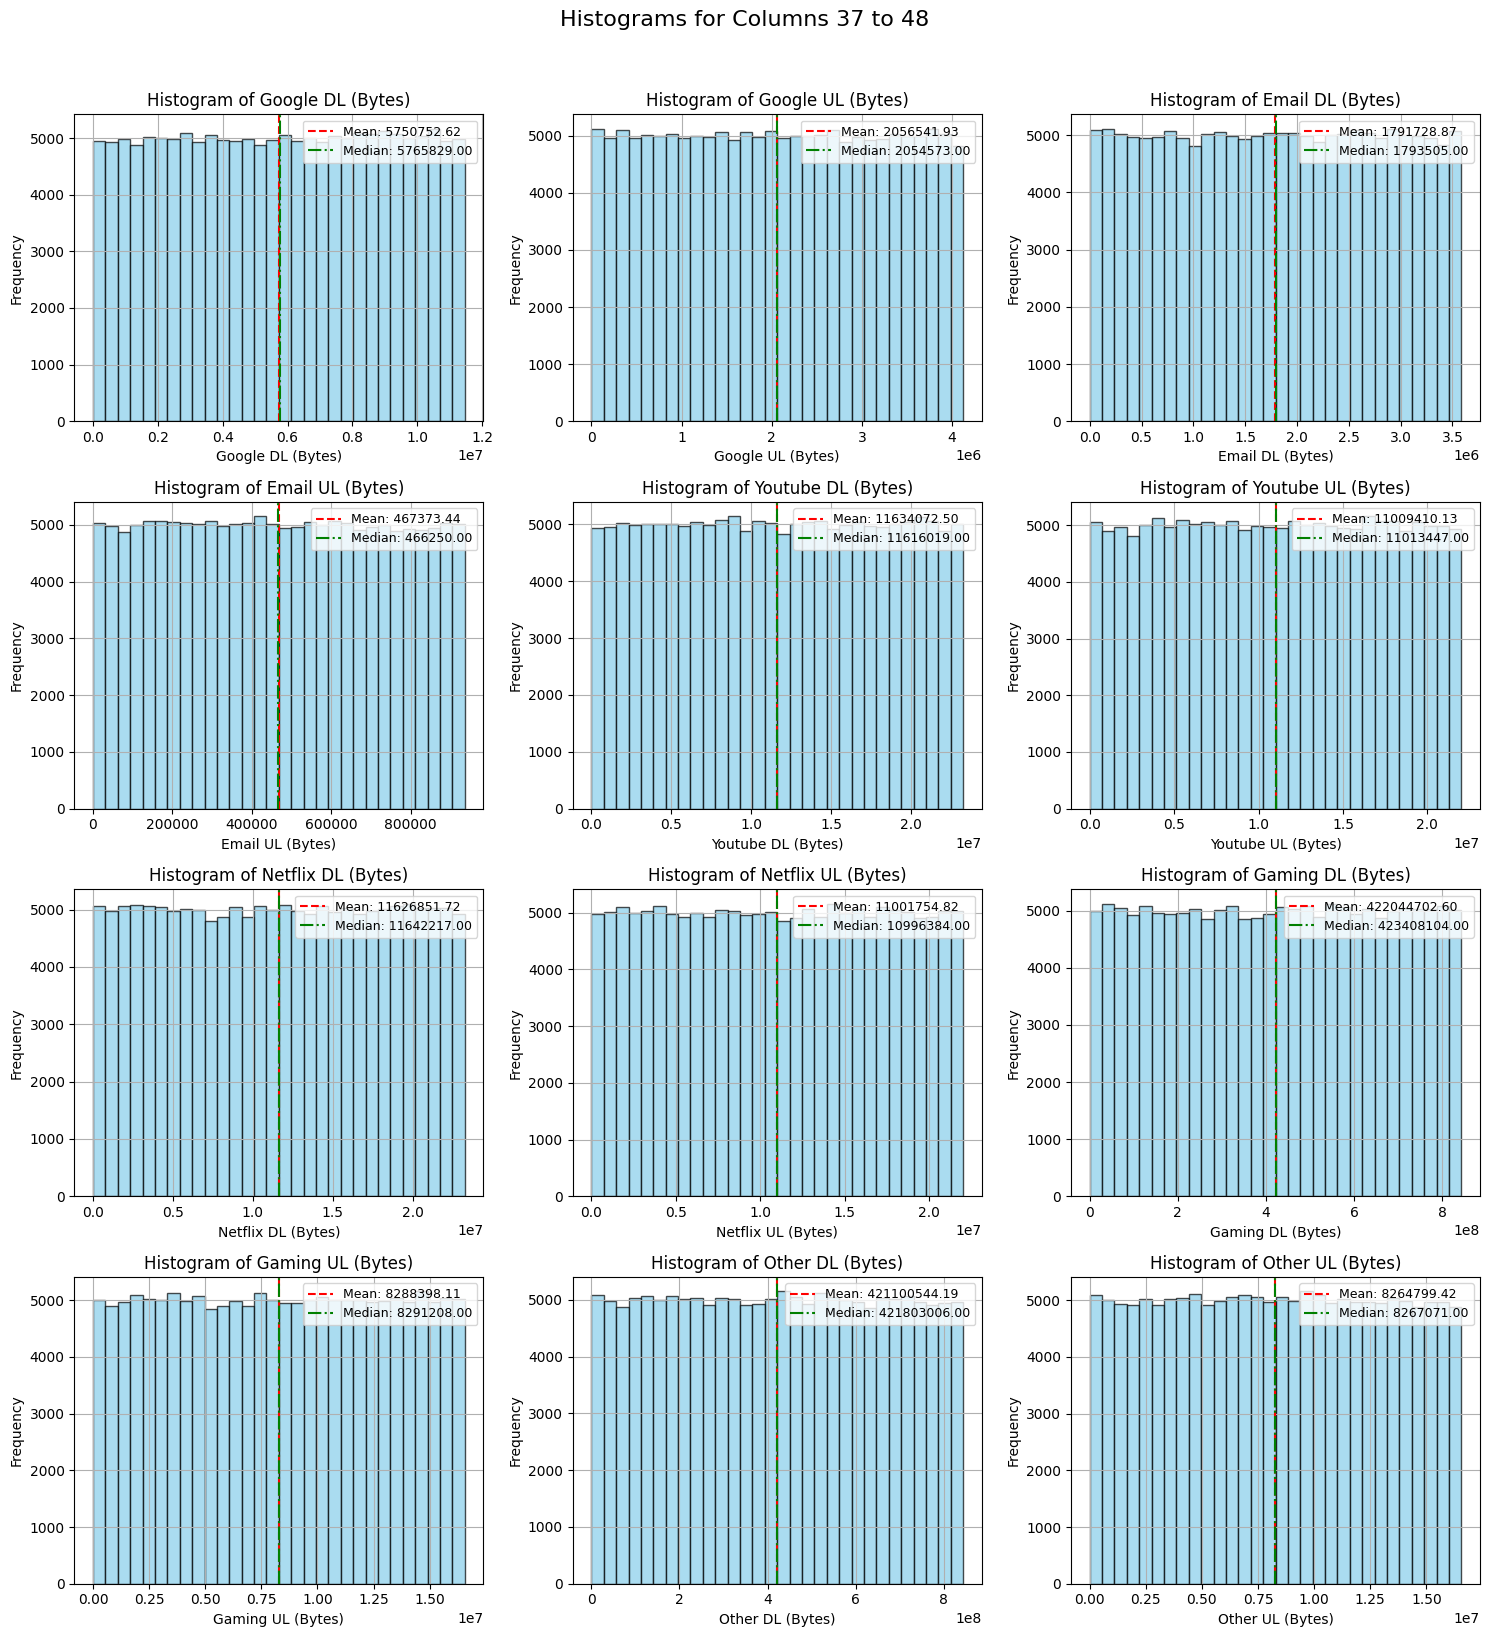

Skewness for columns 49 to 60:
Total UL (Bytes)   -0.002456
Total DL (Bytes)   -0.003153
dtype: float64


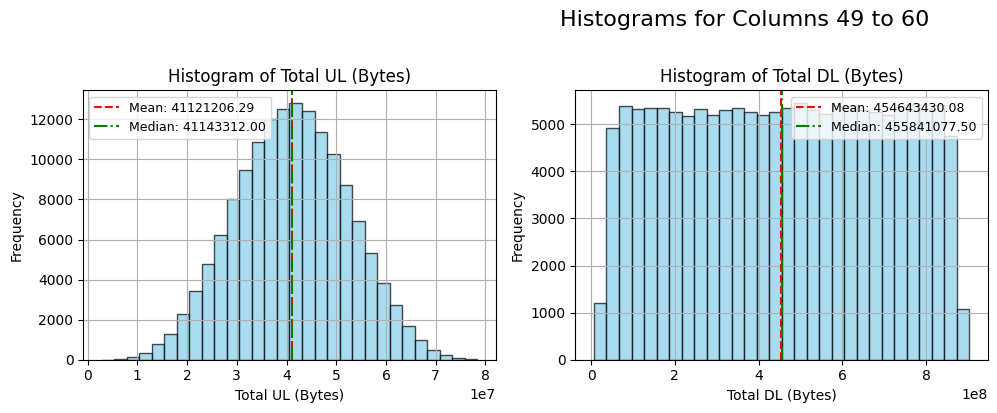

In [10]:
plot_distr.outlier_detection()

The Histogram above show skewness in the graph for columns that have missing a]values are skiwed, so imputing those columns using quantile is better.

In [74]:
def quantile_impute(df, col): # Quantile imputation technique for skewness
    # Check if the column is numeric
    if not pd.api.types.is_numeric_dtype(df[col]):
        print(f"Skipping column '{col}' because it is not numeric.")
        return
    
    skewness = df[col].skew()  # Calculate skewness of the column
    
    # If the skewness is greater than 0 (right-skewed), use a higher quantile (e.g., 75th percentile)
    if skewness > 0:
        quantile_value = df[col].quantile(0.75)  # 75th percentile for right-skewed data
        df[col] = df[col].fillna(quantile_value)

    
    # If the skewness is less than 0 (left-skewed), use a lower quantile (e.g., 25th percentile)
    elif skewness < 0:
        quantile_value = df[col].quantile(0.25)  # 25th percentile for left-skewed data
        df[col] = df[col].fillna(quantile_value)

    
    # If the skewness is approximately 0 (symmetrical), you can choose a quantile around the median (50th percentile)
    else:
        print(f"Approximately symmetric: {col}, applying Quantile Imputation (50th percentile).")
        quantile_value = df[col].quantile(0.50)  # 50th percentile for symmetric data (similar to median)
        df[col] = df[col].fillna(quantile_value)


# Loop over the columns with missing values and apply the quantile imputation strategy
for col in null_columns_greater_than_0:
    quantile_impute(df, col)

Skipping column 'Start' because it is not numeric.
Skipping column 'End' because it is not numeric.
Skipping column 'Last Location Name' because it is not numeric.
Skipping column 'Handset Manufacturer' because it is not numeric.
Skipping column 'Handset Type' because it is not numeric.


In [75]:
df.dropna(inplace=True)

In [76]:
df_cleaned = df
db_instance = Db_Connection()
# Insert the cleaned data into the table
db_instance.insert_cleaned_data(df_cleaned)

# Read back the cleaned_telecom table
cleaned_telecom_data = db_instance.read_data("cleaned_telecom")
print("Cleaned Telecom Data:")
print(cleaned_telecom_data)
# Close the connection
db_instance.close_connection()

Database connection initialized successfully!
Error inserting data: Only %s and %% are supported in the query.
Error reading data: {'S': 'ERROR', 'V': 'ERROR', 'C': '42P01', 'M': 'relation "cleaned_telecom" does not exist', 'P': '15', 'F': 'parse_relation.c', 'L': '1452', 'R': 'parserOpenTable'}
Cleaned Telecom Data:
Empty DataFrame
Columns: []
Index: []
Database connection closed.


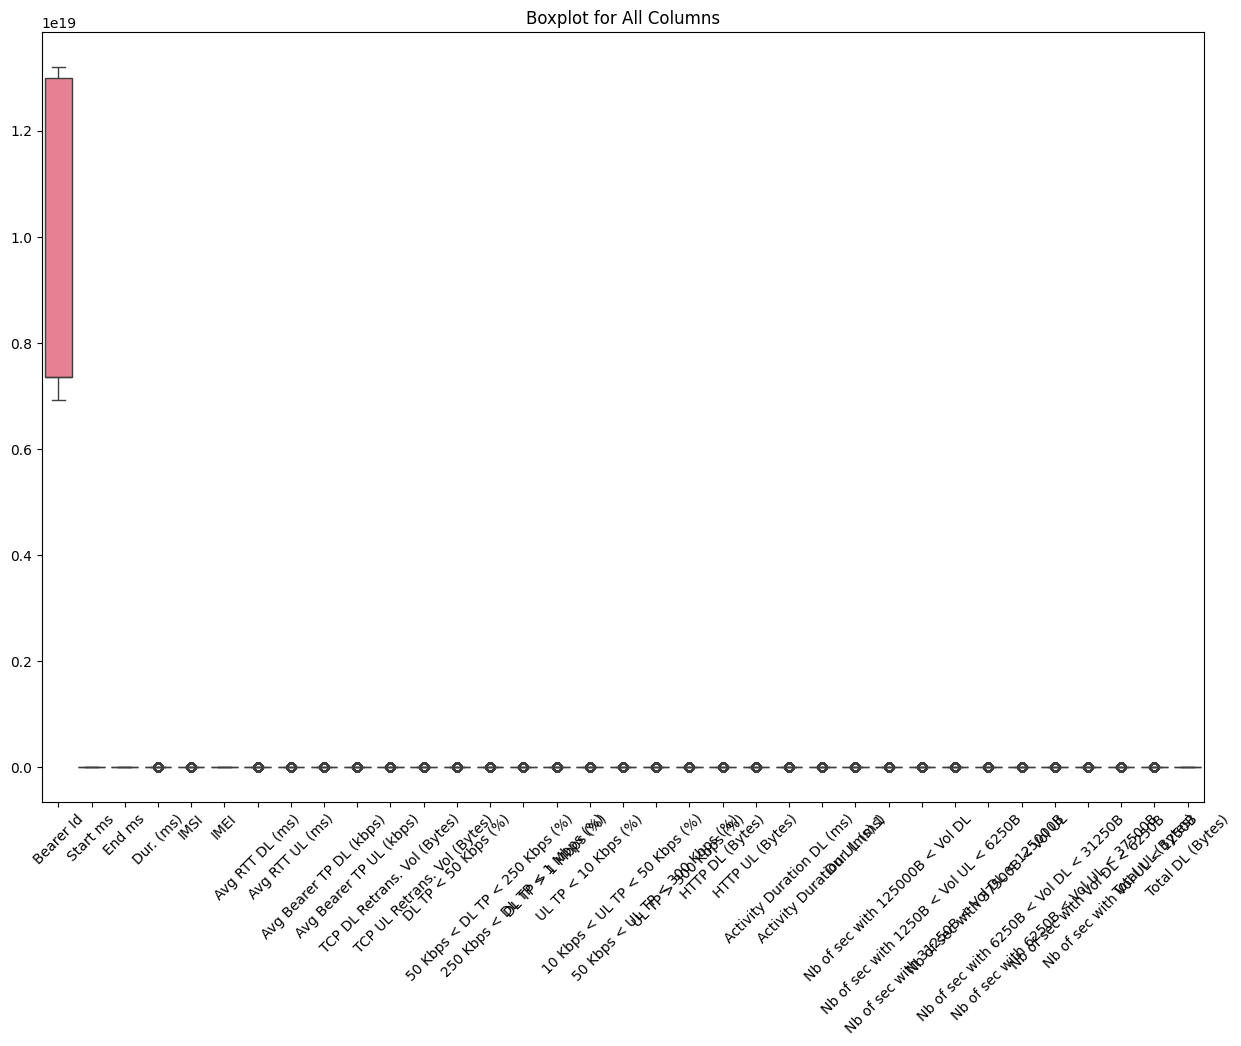

In [77]:
# Boxplots to visualize outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[null_columns_greater_than_0])
plt.xticks(rotation=45)
plt.title("Boxplot for All Columns")
plt.show()

In [ ]:
# Plot histograms for all numerical columns in the dataset to identify outliers.
#processing.plot_histograms()

In [13]:
# Plot histograms for all numerical columns in the dataset in a grid layout.
#processing.plot_histograms_in_grid()

In [4]:
# A summary of outliers for each column, including:
    # Lower and upper bounds.
   #  The number of outliers detected.
processing.detect_outliers()


Outlier Summary (using IQR method):
Bearer Id: {'Lower Bound': np.float64(-1.125e+18), 'Upper Bound': np.float64(2.1475e+19), 'Outlier Count': 0}
Start ms: {'Lower Bound': np.float64(-498.5), 'Upper Bound': np.float64(1497.5), 'Outlier Count': 0}
End ms: {'Lower Bound': np.float64(-497.5), 'Upper Bound': np.float64(1498.5), 'Outlier Count': 0}
Dur. (ms): {'Lower Bound': np.float64(-55044.125), 'Upper Bound': np.float64(244914.875), 'Outlier Count': 7184}
IMSI: {'Lower Bound': np.float64(208199500000000.0), 'Upper Bound': np.float64(208203500000000.0), 'Outlier Count': 3478}
MSISDN/Number: {'Lower Bound': np.float64(33603002800.25), 'Upper Bound': np.float64(33731783550.25), 'Outlier Count': 24130}
IMEI: {'Lower Bound': np.float64(-40527800000000.0), 'Upper Bound': np.float64(162108200000000.0), 'Outlier Count': 0}
Avg RTT DL (ms): {'Lower Bound': np.float64(-25.0), 'Upper Bound': np.float64(127.0), 'Outlier Count': 14059}
Avg RTT UL (ms): {'Lower Bound': np.float64(-17.5), 'Upper Boun

({'Bearer Id': {'Lower Bound': np.float64(-1.125e+18),
   'Upper Bound': np.float64(2.1475e+19),
   'Outlier Count': 0},
  'Start ms': {'Lower Bound': np.float64(-498.5),
   'Upper Bound': np.float64(1497.5),
   'Outlier Count': 0},
  'End ms': {'Lower Bound': np.float64(-497.5),
   'Upper Bound': np.float64(1498.5),
   'Outlier Count': 0},
  'Dur. (ms)': {'Lower Bound': np.float64(-55044.125),
   'Upper Bound': np.float64(244914.875),
   'Outlier Count': 7184},
  'IMSI': {'Lower Bound': np.float64(208199500000000.0),
   'Upper Bound': np.float64(208203500000000.0),
   'Outlier Count': 3478},
  'MSISDN/Number': {'Lower Bound': np.float64(33603002800.25),
   'Upper Bound': np.float64(33731783550.25),
   'Outlier Count': 24130},
  'IMEI': {'Lower Bound': np.float64(-40527800000000.0),
   'Upper Bound': np.float64(162108200000000.0),
   'Outlier Count': 0},
  'Avg RTT DL (ms)': {'Lower Bound': np.float64(-25.0),
   'Upper Bound': np.float64(127.0),
   'Outlier Count': 14059},
  'Avg RTT U

# User Overview analysis 

In [20]:
overiew_anal = overview(df)

In [21]:
# Identify the top 10 most frequently used handsets.
overiew_anal.identify_top10_handsets()


Top 10 Handsets Used by Customers:


,Handset Type,Count
0,Huawei B528S-23A,19752
1,Apple iPhone 6S (A1688),9419
2,Apple iPhone 6 (A1586),9023
3,undefined,8987
4,Apple iPhone 7 (A1778),6326
5,Apple iPhone Se (A1723),5187
6,Apple iPhone 8 (A1905),4993
7,Apple iPhone Xr (A2105),4568
8,Samsung Galaxy S8 (Sm-G950F),4520
9,Apple iPhone X (A1901),3813


In [84]:
# Identify the top 3 manufacturers.
overiew_anal.top3_manufacturers()


Top 3 Handset Manufacturers:


,Manufacturer,Count
0,Apple,59304
1,Samsung,40393
2,Huawei,34269


#### Extracting the top 3 manufacturer name those have frequently used handsets. (Assuming manufacturer is the first word in the handset name) 

In [22]:
overiew_anal.xdr_sessions1()

,IMSI,Number_of_xDR_Sessions
36781,208201402778052,18
71849,208201715944176,17
15895,208201007176097,17
88187,208201906760163,16
25251,208201009693091,15
...,...,...
105470,208209850542213,0
105507,208209850547006,0
105744,208209850569111,0
106602,208209850678000,0


In [23]:
overiew_anal.session_duration()

,IMSI,Total_UL,Total_DL,Total_Duration,Session Duration (hours)
0,204047108489451,60456049,78697597,870,0
1,204080810288647,37295915,194828056,877,0
2,208200101016140,53794658,31376981,86,0
3,208200101127285,33583272,392918313,86,0
4,208200101148045,71325004,961767023,574,0
...,...,...,...,...,...
107260,208209850788090,33888182,688815403,127,0
107261,208209850788245,44692550,451173021,169,0
107262,208209850788283,30355487,307825104,86,0
107263,208252167239575,45083854,800629358,57,0


In [24]:
overiew_anal.total_DL_UP()

,IMSI,number_of_sessions,total_session_duration,total_download,total_upload,youtube_dl,youtube_ul,netflix_dl,netflix_ul,gaming_dl,gaming_ul,other_dl,other_ul
0,204047108489451,1,869844,78697597,60456049,18980320,21960390,21621336,7224894,28092282,14977978,389159720,12200737
1,204080810288647,1,877385,194828056,37295915,9839889,2120016,10340908,16251392,164563605,13485133,467678100,2848373
2,208200101016140,1,86019,31376981,53794658,5556563,14325876,15305361,16525201,3760934,5363582,500044526,15929178
3,208200101127285,1,86254,392918313,33583272,22414714,3242918,10065639,17720213,343946503,159394,300902853,8707888
4,208200101148045,2,573923,961767023,71325004,4046597,9793604,30748449,26594966,910301321,7383445,1055868839,23566580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107260,208209850788090,1,127367,688815403,33888182,8661662,2959812,5726631,5040884,664258019,14235971,580834171,7560085
107261,208209850788245,1,168543,451173021,44692550,23251957,11605503,14193266,16541988,408071389,3311290,743771852,8852044
107262,208209850788283,1,86399,307825104,30355487,22196893,6993803,15051715,4554026,264956718,7089918,448153093,8582273
107263,208252167239575,1,56613,800629358,45083854,12776130,12133368,9816072,1098136,773183701,15385758,579109652,15370837


In [25]:
overiew_anal.total_DL_UP_app()

,IMSI,Total Youtube (Bytes) DL_UL,Total Netflix (Bytes) DL_UL,Total Gaming (Bytes) DL_UL,Total Other (Bytes) DL_UL
0,204047108489451,40940710,28846230,43070260,401360457
1,204080810288647,11959905,26592300,178048738,470526473
2,208200101016140,19882439,31830562,9124516,515973704
3,208200101127285,25657632,27785852,344105897,309610741
4,208200101148045,13840201,57343415,917684766,1079435419
5,208200101148074,19596808,34177184,632745679,549222257
6,208200101148075,50907243,29882137,835218898,479778260
7,208200101148136,11823461,17047546,939598732,1069429486
8,208200101148139,16310061,25274811,400273809,799065942
9,208200101148152,35885492,25595503,290007171,354263472


# Segment Users into Decile Classes

In [26]:
# Analyze the basic metrics (mean, median, etc) in the Dataset (explain) & their importance for the global objective
decile_segm = EDA(df)
decile_segm1 = decile_segm.segment()
decile_segm1

(   Decile  Total Data (Bytes)  Total Youtube (Bytes)  Total Netflix (Bytes)  \
 0       1       9956995904878           249655439888           250309457365   
 1       2      11079699106664           277094601075           278688633545   
 2       3      11951524855291           299463781023           300410223406   
 3       4      11312543197608           282705510886           280198891290   
 4       5       9300594758495           229837264225           231535886075   
 5       6      11810486060553           294228486759           294190414134   
 6       7      11210564793106           280571019959           277528220081   
 7       8      14316237939268           359011537884           359088278350   
 8       9      17036389516906           425641666632           426564759994   
 9      10      27262012310865           685251864687           682669977276   
 
    Total Gaming (Bytes)  Total Other (Bytes)  
 0         4736814367554        4720216640071  
 1         53011190734

### Analyze the basic metrics (mean, median, etc) in the Dataset (explain) & their importance for the global objective

In [9]:
# 1. Aggregate data by IMSI for total duration and data usage
aggregated_data = df.groupby('IMSI').agg({
    'Dur. (ms)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum',
}).reset_index()

# 2. Calculate the total data volume (Download + Upload) for each application
aggregated_data['Total Youtube (Bytes)'] = aggregated_data['Youtube DL (Bytes)'] + aggregated_data['Youtube UL (Bytes)']
aggregated_data['Total Netflix (Bytes)'] = aggregated_data['Netflix DL (Bytes)'] + aggregated_data['Netflix UL (Bytes)']
aggregated_data['Total Gaming (Bytes)'] = aggregated_data['Gaming DL (Bytes)'] + aggregated_data['Gaming UL (Bytes)']
aggregated_data['Total Other (Bytes)'] = aggregated_data['Other DL (Bytes)'] + aggregated_data['Other UL (Bytes)']

# 3. Calculate the total data volume across all applications
aggregated_data['Total Data (Bytes)'] = aggregated_data[['Total Youtube (Bytes)', 'Total Netflix (Bytes)', 'Total Gaming (Bytes)', 'Total Other (Bytes)']].sum(axis=1)

# 4. Segment users into decile classes based on total session duration
aggregated_data['Decile'] = pd.qcut(aggregated_data['Dur. (ms)'], 10, labels=False) + 1  # Labels from 1 to 10 for deciles

# 5. Compute total data (DL + UL) per decile class
decile_data = aggregated_data.groupby('Decile').agg({
    'Total Data (Bytes)': 'sum',
    'Total Youtube (Bytes)': 'sum',
    'Total Netflix (Bytes)': 'sum',
    'Total Gaming (Bytes)': 'sum',
    'Total Other (Bytes)': 'sum',
}).reset_index()

# Display the result
decile_data

# Save the results to a CSV file
#aggregated_data.to_csv('Overview_analysis.csv', index=False)

,Decile,Total Data (Bytes),Total Youtube (Bytes),Total Netflix (Bytes),Total Gaming (Bytes),Total Other (Bytes)
0,1,9.956996e+12,2.496554e+11,2.503095e+11,4.736814e+12,4.720217e+12
1,2,1.107970e+13,2.770946e+11,2.786886e+11,5.301119e+12,5.222797e+12
2,3,1.195152e+13,2.994638e+11,3.004102e+11,5.686967e+12,5.664684e+12
3,4,1.131254e+13,2.827055e+11,2.801989e+11,5.364457e+12,5.385182e+12
4,5,9.300595e+12,2.298373e+11,2.315359e+11,4.402895e+12,4.436327e+12
5,6,1.181049e+13,2.942285e+11,2.941904e+11,5.602001e+12,5.620067e+12
6,7,1.121056e+13,2.805710e+11,2.775282e+11,5.369636e+12,5.282829e+12
7,8,1.431624e+13,3.590115e+11,3.590883e+11,6.804469e+12,6.793670e+12
8,9,1.703639e+13,4.256417e+11,4.265648e+11,8.098532e+12,8.085651e+12
9,10,2.726201e+13,6.852519e+11,6.826700e+11,1.293933e+13,1.295476e+13


In [90]:
metrics = aggregated_data[['Dur. (ms)', 'Total Data (Bytes)', 'Total Youtube (Bytes)', 'Total Netflix (Bytes)', 'Total Gaming (Bytes)', 'Total Other (Bytes)']].describe()

# Calculate additional metrics like median, and standard deviation
median_values = aggregated_data.median()
std_deviation = aggregated_data.std()

# Print the basic metrics
metrics

,Dur. (ms),Total Data (Bytes),Total Youtube (Bytes),Total Netflix (Bytes),Total Gaming (Bytes),Total Other (Bytes)
count,7,7,7,7,7,7
mean,2227932016,19180932545377,479857482615,479567566383,9120936160684,9100571335696
std,3462073069,30089020295524,752507093330,751866484595,14299386302200,14285273569715
min,56613,514217657,11959905,10914208,43070260,401360457
25%,873614,1053000535,32925104,27719265,483309098,532503481
50%,425679446,3125266164697,78163223279,77917741387,1503106750143,1466078449888
75%,3259242949,27752116307290,695361495856,695140883838,13202498419058,13159115508538
max,8649554928,75634408819638,1890038353200,1888707102878,35937439848074,35918223515486


In [20]:
print("Median values:\n")
median_values

Median values:



IMSI                     2.082015e+14
Dur. (ms)                1.029280e+05
Youtube DL (Bytes)       1.460527e+07
Youtube UL (Bytes)       1.388011e+07
Netflix DL (Bytes)       1.464004e+07
Netflix UL (Bytes)       1.388325e+07
Gaming DL (Bytes)        5.326555e+08
Gaming UL (Bytes)        1.044714e+07
Other DL (Bytes)         5.299480e+08
Other UL (Bytes)         1.037932e+07
Total Youtube (Bytes)    2.680201e+07
Total Netflix (Bytes)    2.672084e+07
Total Gaming (Bytes)     5.424845e+08
Total Other (Bytes)      5.397970e+08
Total Data (Bytes)       1.064509e+09
Decile                   5.000000e+00
dtype: float64

In [21]:
print("Standard Deviation values:\n")
std_deviation

Standard Deviation values:



IMSI                     2.540990e+10
Dur. (ms)                1.861138e+05
Youtube DL (Bytes)       1.232863e+07
Youtube UL (Bytes)       1.159938e+07
Netflix DL (Bytes)       1.232438e+07
Netflix UL (Bytes)       1.161066e+07
Gaming DL (Bytes)        4.442820e+08
Gaming UL (Bytes)        8.737437e+06
Other DL (Bytes)         4.439738e+08
Other UL (Bytes)         8.710434e+06
Total Youtube (Bytes)    2.130237e+07
Total Netflix (Bytes)    2.129784e+07
Total Gaming (Bytes)     4.494115e+08
Total Other (Bytes)      4.491213e+08
Total Data (Bytes)       8.321693e+08
Decile                   2.876741e+00
dtype: float64

## Non-Graphical Univariate Analysis

In [18]:
# Calculate the dispersion parameters manually for each quantitative variable
dispersion_metrics = aggregated_data[['Dur. (ms)', 'Total Data (Bytes)', 
                                      'Total Youtube (Bytes)', 'Total Netflix (Bytes)', 
                                      'Total Gaming (Bytes)', 'Total Other (Bytes)']]

# Min, max, mean, standard deviation, variance
min_vals = dispersion_metrics.min()
max_vals = dispersion_metrics.max()
mean_vals = dispersion_metrics.mean()
std_vals = dispersion_metrics.std()
var_vals = dispersion_metrics.var()

# 25th, 50th (median), and 75th percentiles
percentiles_25 = dispersion_metrics.quantile(0.25)
percentiles_50 = dispersion_metrics.quantile(0.50)
percentiles_75 = dispersion_metrics.quantile(0.75)

# Range and Interquartile Range (IQR)
range_vals = max_vals - min_vals
IQR_vals = percentiles_75 - percentiles_25

# Create a final DataFrame with all dispersion parameters
dispersion_summary = pd.DataFrame({
    'min': min_vals,
    'max': max_vals,
    'mean': mean_vals,
    'std': std_vals,
    'variance': var_vals,
    '25th_percentile': percentiles_25,
    '50th_percentile': percentiles_50,
    '75th_percentile': percentiles_75,
    'range': range_vals,
    'IQR': IQR_vals
})

# Print the results
dispersion_metrics

,Dur. (ms),Total Data (Bytes),Total Youtube (Bytes),Total Netflix (Bytes),Total Gaming (Bytes),Total Other (Bytes)
0,869844.0,5.142177e+08,40940710.0,28846230.0,43070260.0,4.013605e+08
1,877385.0,6.871274e+08,11959905.0,26592300.0,178048738.0,4.705265e+08
2,86019.0,5.768112e+08,19882439.0,31830562.0,9124516.0,5.159737e+08
3,86254.0,7.071601e+08,25657632.0,27785852.0,344105897.0,3.096107e+08
4,573923.0,2.068304e+09,13840201.0,57343415.0,917684766.0,1.079435e+09
...,...,...,...,...,...,...
106752,127367.0,1.289277e+09,11621474.0,10767515.0,678493990.0,5.883943e+08
106753,168543.0,1.229599e+09,34857460.0,30735254.0,411382679.0,7.526239e+08
106754,86399.0,7.775784e+08,29190696.0,19605741.0,272046636.0,4.567354e+08
106755,56613.0,1.418874e+09,24909498.0,10914208.0,788569459.0,5.944805e+08


# Univariate Analysis

### Plot Histogram: Distribution of quantitative variables.

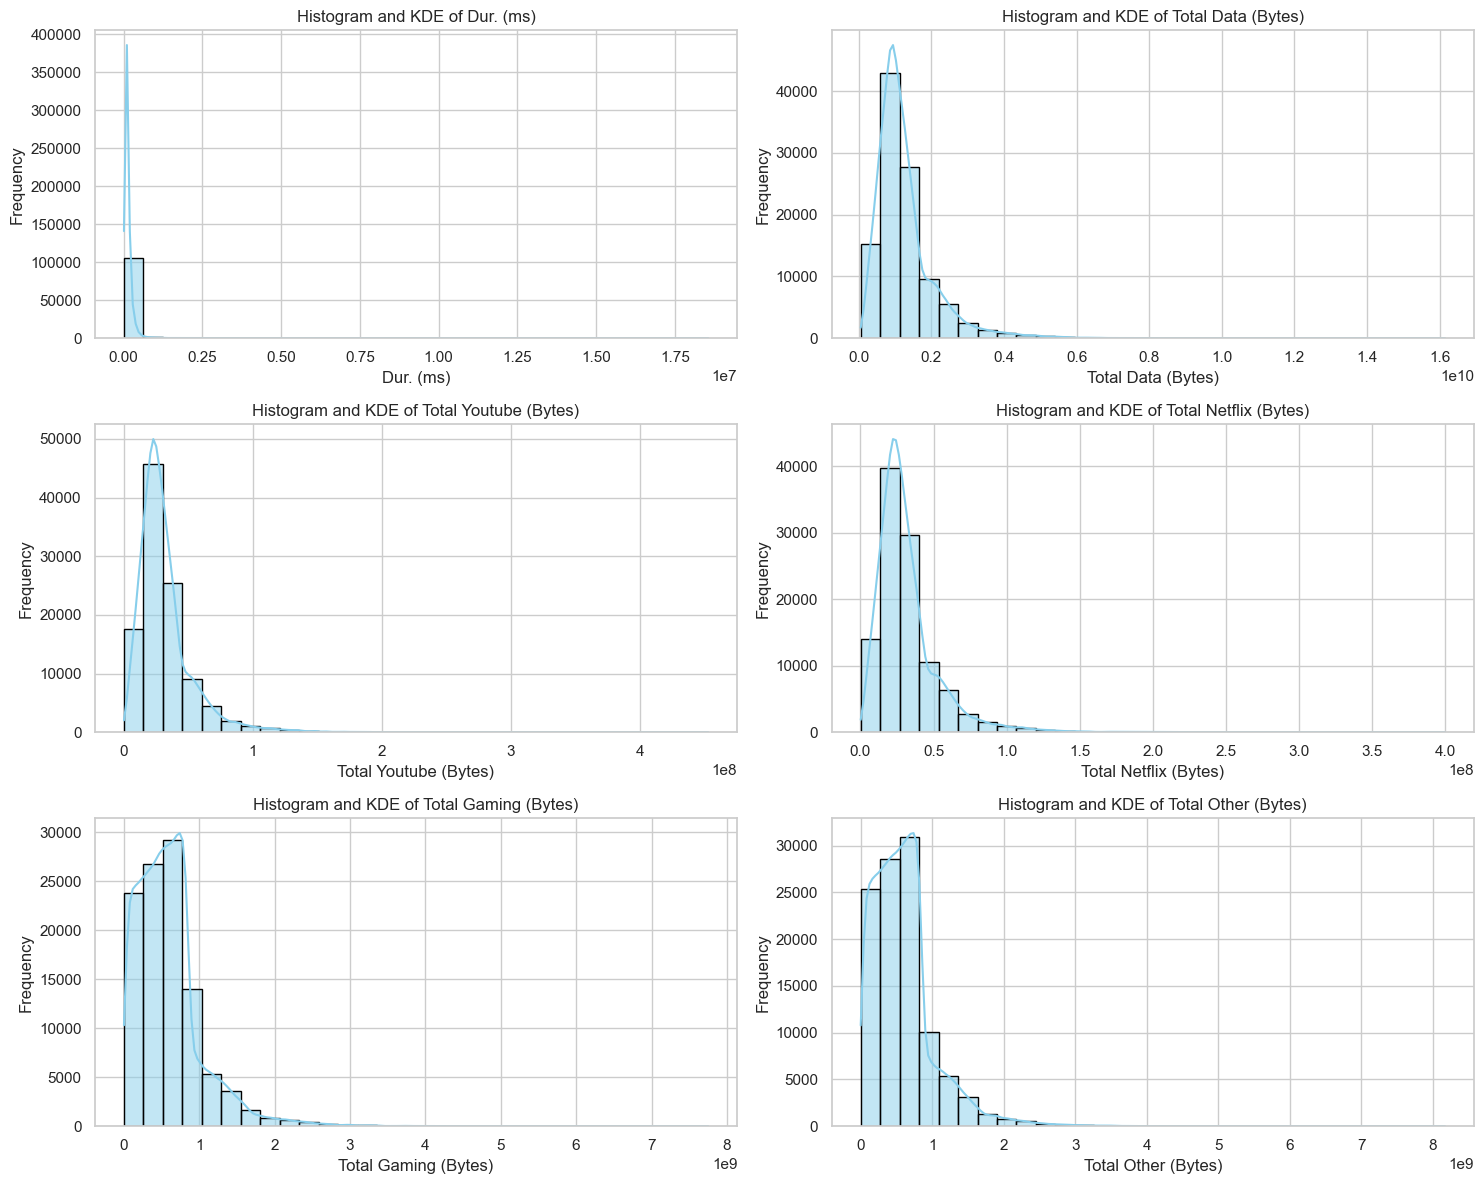

In [23]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# List of the quantitative variables to plot
quantitative_vars = ['Dur. (ms)', 'Total Data (Bytes)', 'Total Youtube (Bytes)', 
                     'Total Netflix (Bytes)', 'Total Gaming (Bytes)', 'Total Other (Bytes)']

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot each variable in a subplot
for i, var in enumerate(quantitative_vars):
    ax = axes[i // 2, i % 2]  # Determine position of subplot (3 rows, 2 columns)
    
    # Histogram
    sns.histplot(aggregated_data[var], bins=30, kde=True, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram and KDE of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')
    
# Adjust layout for readability
plt.tight_layout()
plt.show()

### Box Plot: Outliers and spread.

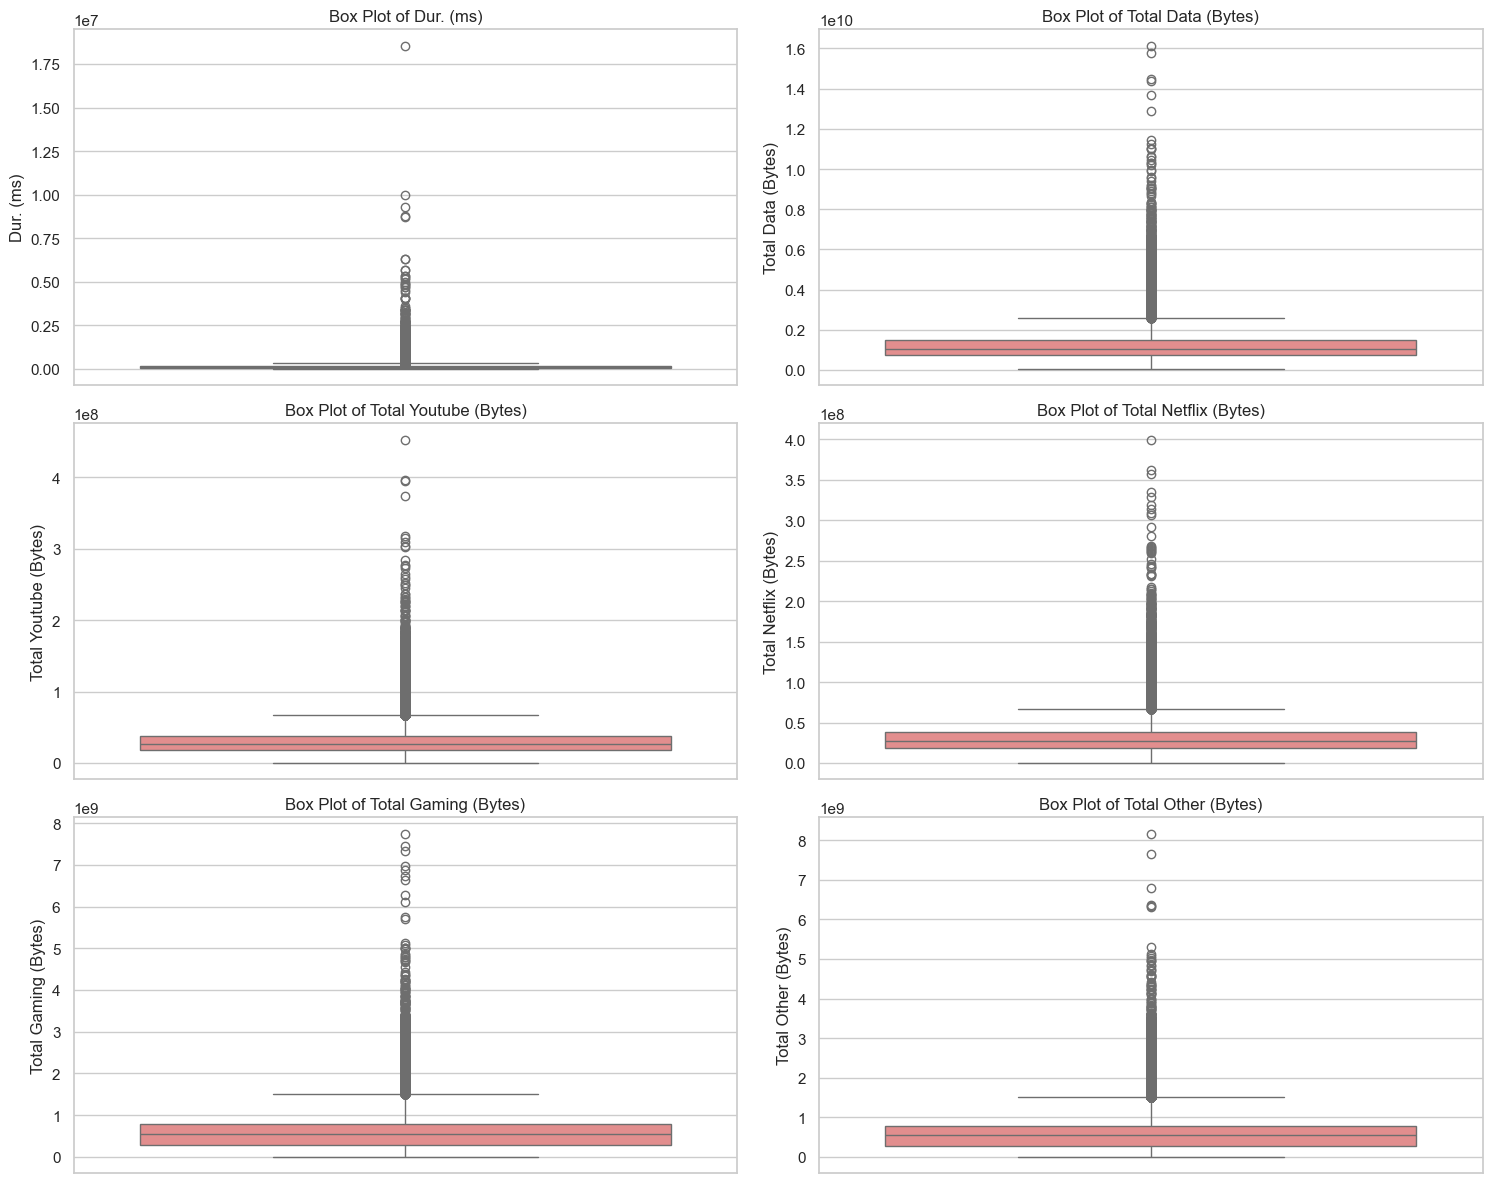

In [30]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot each variable in a subplot
for i, var in enumerate(quantitative_vars):
    ax = axes[i // 2, i % 2]  # Determine position of subplot (3 rows, 2 columns)
    
    # Box plot
    sns.boxplot(data=aggregated_data, y=var, ax=ax, color='lightcoral')
    ax.set_title(f'Box Plot of {var}')
    ax.set_xlabel('')  # No x-axis label needed for box plot
    ax.set_ylabel(var)
    
# Adjust layout for readability
plt.tight_layout()
plt.show()

### Bar Plot: Total data by decile class.

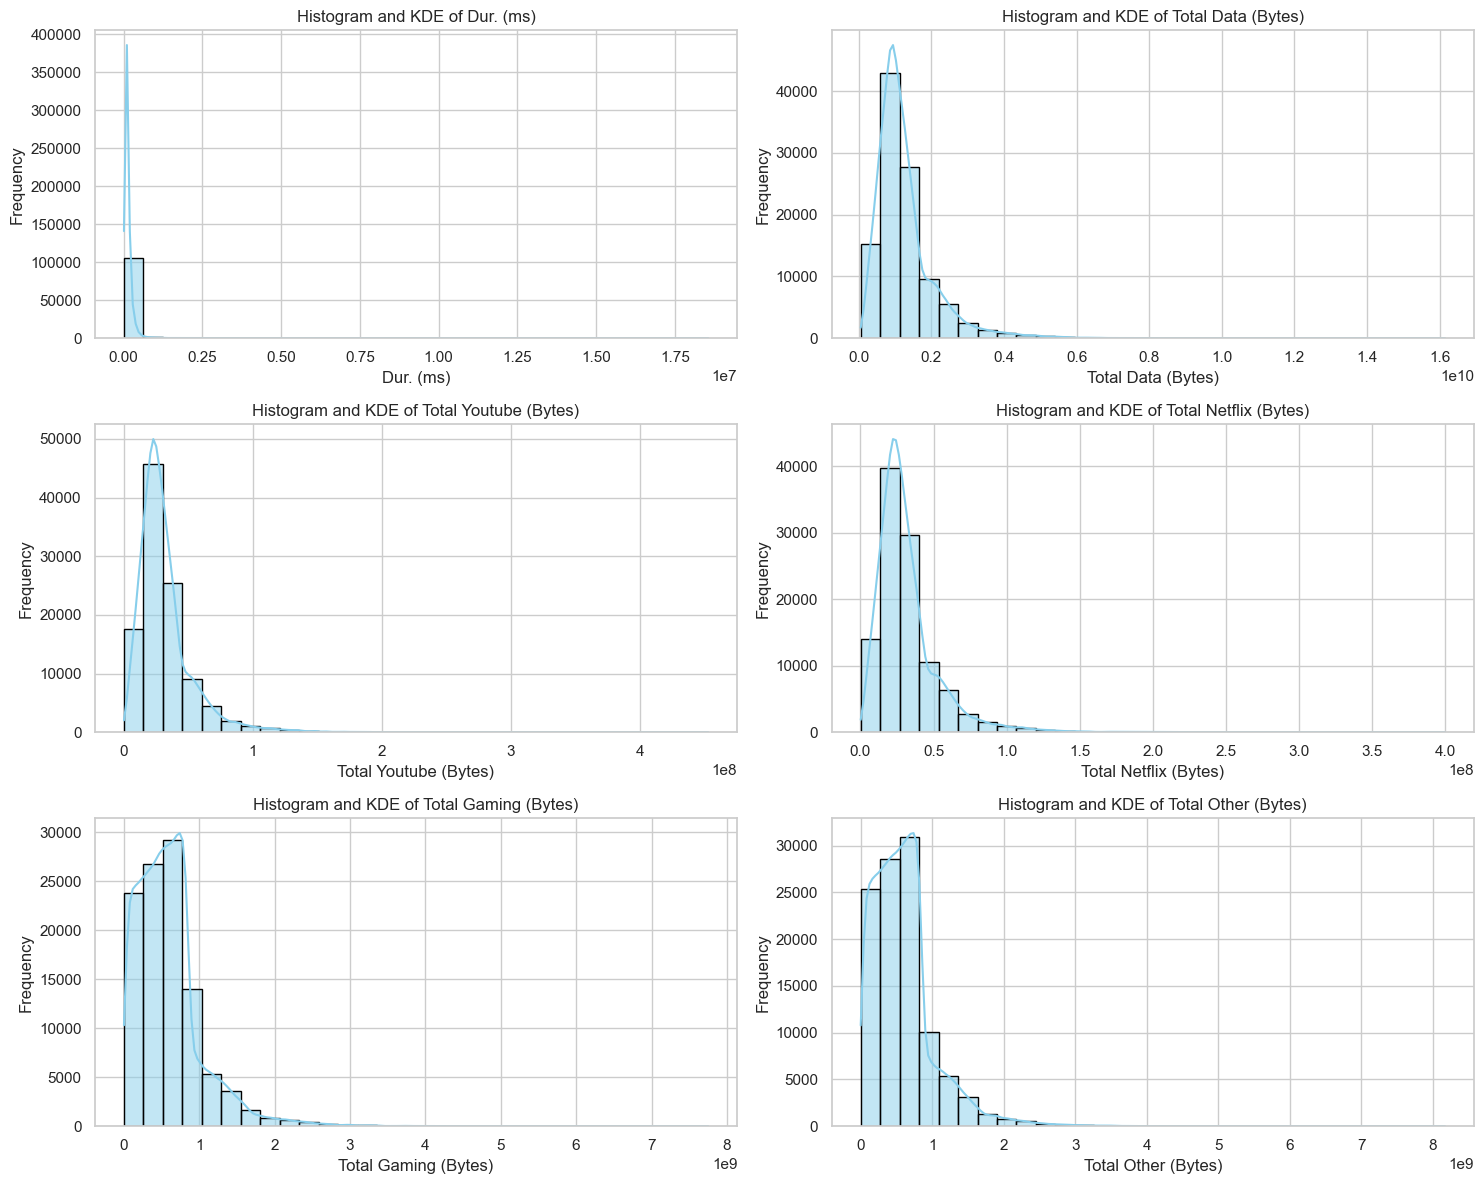

In [31]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# List of the quantitative variables to plot
quantitative_vars = ['Dur. (ms)', 'Total Data (Bytes)', 'Total Youtube (Bytes)', 
                     'Total Netflix (Bytes)', 'Total Gaming (Bytes)', 'Total Other (Bytes)']

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot each variable in a subplot
for i, var in enumerate(quantitative_vars):
    ax = axes[i // 2, i % 2]  # Determine position of subplot (3 rows, 2 columns)
    
    # Histogram
    sns.histplot(aggregated_data[var], bins=30, kde=True, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram and KDE of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')
    
# Adjust layout for readability
plt.tight_layout()
plt.show()


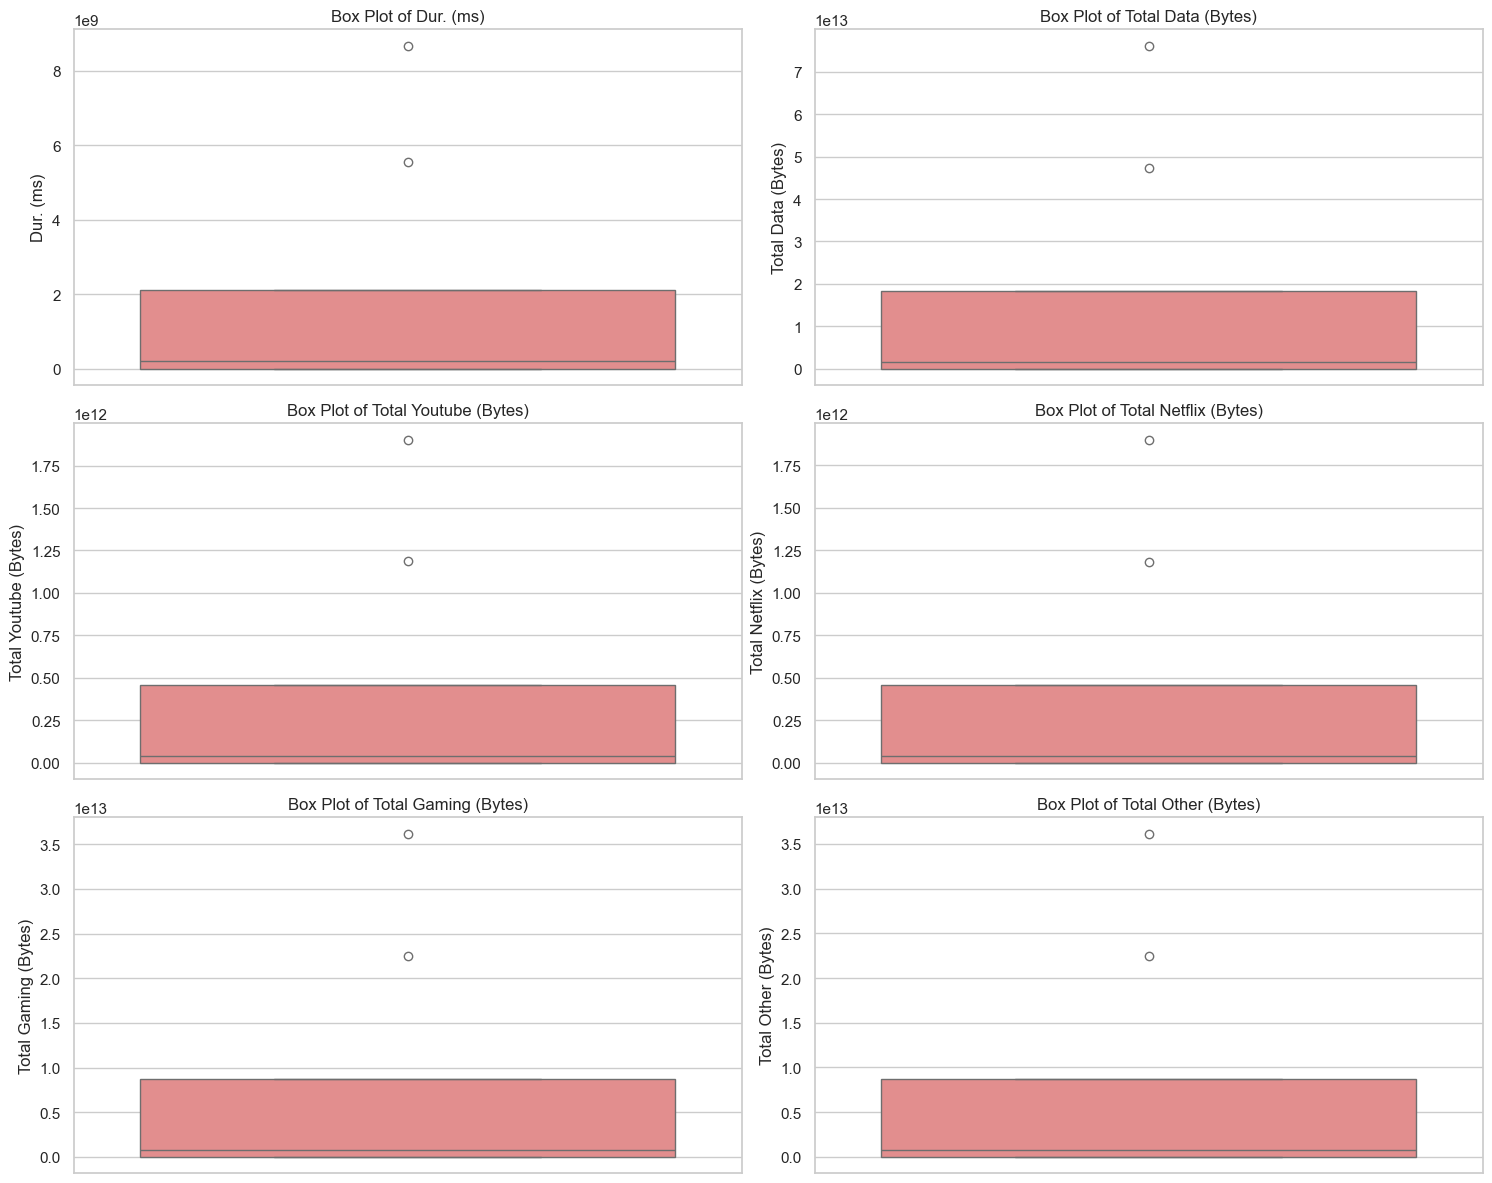

In [32]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot each variable in a subplot
for i, var in enumerate(quantitative_vars):
    ax = axes[i // 2, i % 2]  # Determine position of subplot (3 rows, 2 columns)
    
    # Box plot
    sns.boxplot(data=aggregated_data, y=var, ax=ax, color='lightcoral')
    ax.set_title(f'Box Plot of {var}')
    ax.set_xlabel('')  # No x-axis label needed for box plot
    ax.set_ylabel(var)
    
# Adjust layout for readability
plt.tight_layout()
plt.show()

# Bivariate Analysis
### Relationship Between Applications and Total Data

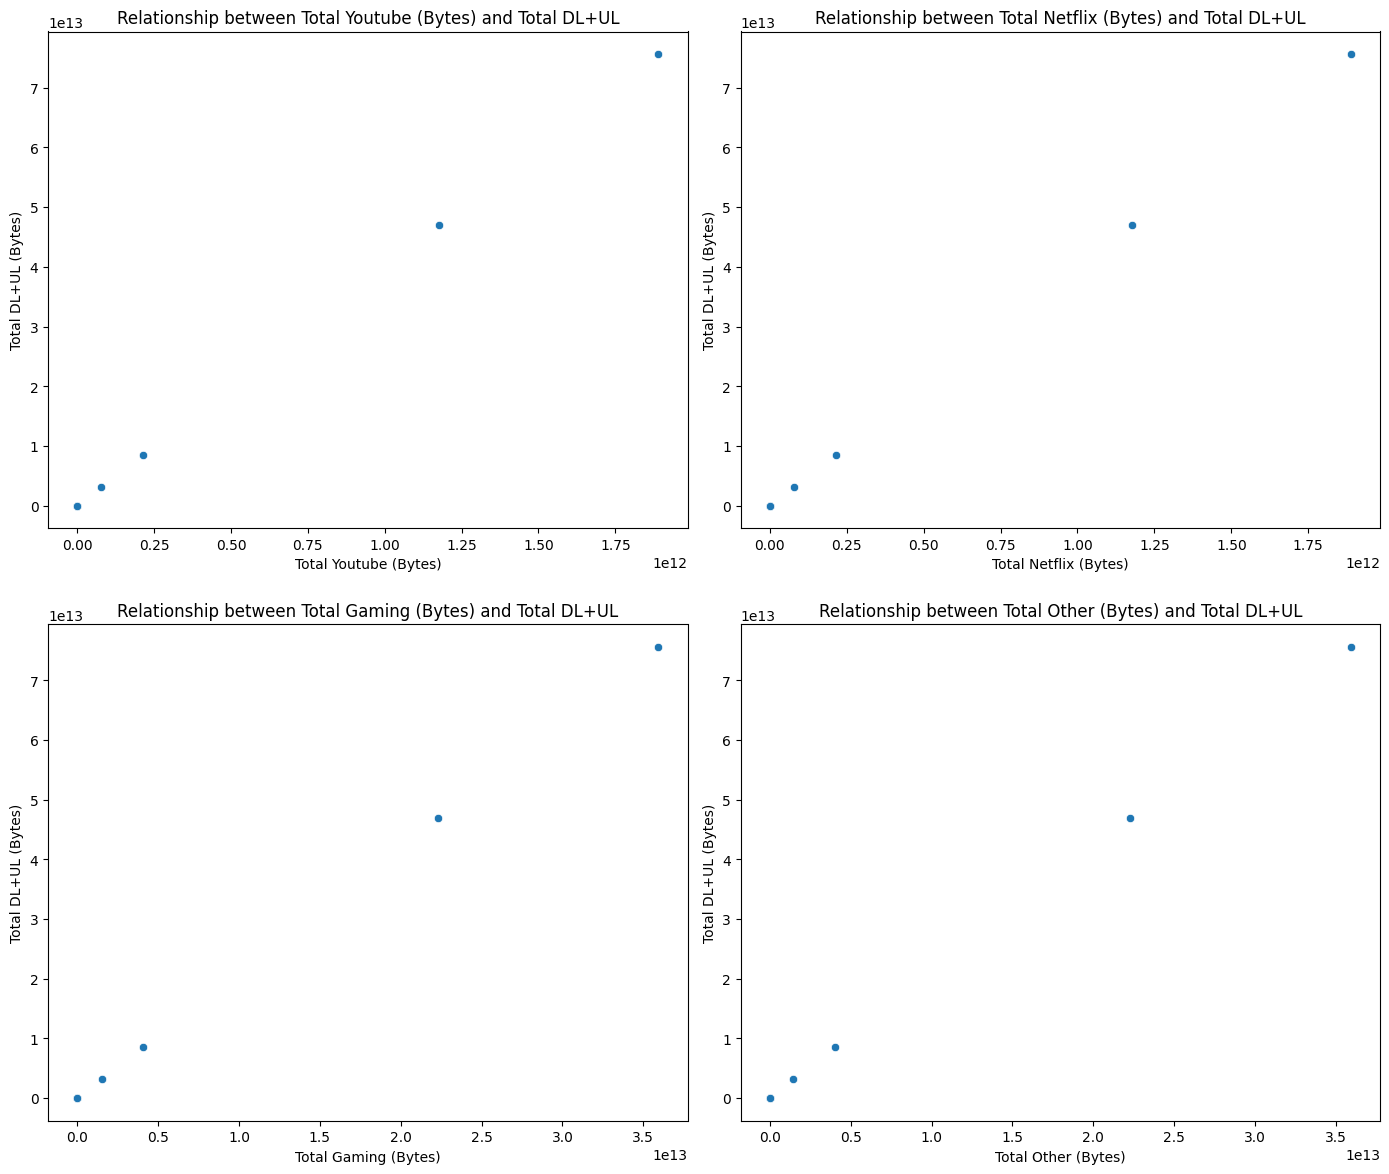

In [91]:
# Create a new column for the total data (DL+UL)
aggregated_data['Total DL+UL (Bytes)'] = (aggregated_data['Total Youtube (Bytes)'] + 
                                           aggregated_data['Total Netflix (Bytes)'] + 
                                           aggregated_data['Total Gaming (Bytes)'] + 
                                           aggregated_data['Total Other (Bytes)'])

# List of applications to explore
applications = ['Total Youtube (Bytes)', 'Total Netflix (Bytes)', 
                'Total Gaming (Bytes)', 'Total Other (Bytes)']

# Create a figure to hold scatter plots for each application vs Total DL+UL
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Loop through each application and plot scatter plots
for i, app in enumerate(applications):
    ax = axes[i // 2, i % 2]  # Determine subplot position
    
    # Scatter plot of the relationship between application data and total data
    sns.scatterplot(x=aggregated_data[app], y=aggregated_data['Total DL+UL (Bytes)'], ax=ax)
    ax.set_title(f'Relationship between {app} and Total DL+UL')
    ax.set_xlabel(app)
    ax.set_ylabel('Total DL+UL (Bytes)')
    
# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [10]:
# Define the columns to be used for correlation analysis
columns_to_analyze = [#'Social Media (Bytes)', 'Google (Bytes)', 'Email (Bytes)',
                      'Total Youtube (Bytes)', 'Total Netflix (Bytes)', 'Total Gaming (Bytes)', 'Total Other (Bytes)']

# Compute the correlation matrix
correlation_matrix = aggregated_data[columns_to_analyze].corr()
correlation_matrix

,Total Youtube (Bytes),Total Netflix (Bytes),Total Gaming (Bytes),Total Other (Bytes)
Total Youtube (Bytes),1.000000,0.738396,0.657449,0.660284
Total Netflix (Bytes),0.738396,1.000000,0.657473,0.655745
Total Gaming (Bytes),0.657449,0.657473,1.000000,0.586485
Total Other (Bytes),0.660284,0.655745,0.586485,1.000000


In [93]:
print(aggregated_data.columns)

Index(['IMSI', 'Dur. (ms)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
       'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
       'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)',
       'Total Youtube (Bytes)', 'Total Netflix (Bytes)',
       'Total Gaming (Bytes)', 'Total Other (Bytes)', 'Total Data (Bytes)',
       'Decile', 'Total DL+UL (Bytes)'],
      dtype='object')


# Correlation Analysis

Text(0.5, 1.0, 'Correlation Matrix')

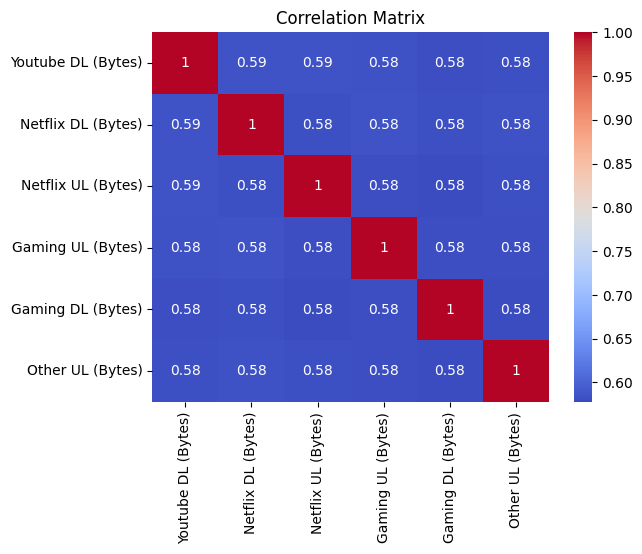

In [11]:
variables = ['social_media_dl', 'google_dl', 'email_dl', 
             'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other UL (Bytes)']

variables = ['Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming UL (Bytes)', 'Gaming DL (Bytes)', 'Other UL (Bytes)']

correlation_matrix = aggregated_data[variables].corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
#plt.show()

## Dimensionality Reduction Using Principal Component Analysis (PCA)

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume 'aggregated_data' contains the relevant data columns for PCA
# Select relevant columns (data usage for different applications)
columns_to_pca = [#'Social Media (Bytes)', 'Google (Bytes)', 'Email (Bytes)', 
                  'Total Youtube (Bytes)', 'Total Netflix (Bytes)', 
                  'Total Gaming (Bytes)', 'Total Other (Bytes)']

# Step 1: Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(aggregated_data[columns_to_pca])

# Step 2: Perform PCA
pca = PCA()
pca.fit(data_scaled)

# Step 3: Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Step 5: Show the results
print("Explained Variance Ratio for each component:")
print(explained_variance_ratio)

print("\nCumulative Explained Variance:")
print(cumulative_explained_variance)

# Optionally, to reduce the data to fewer dimensions (e.g., 2 components):
pca_2d = PCA(n_components=2)
reduced_data = pca_2d.fit_transform(data_scaled)

# Show the first 2 principal components for a reduced dataset (2D representation)
print("\nFirst 2 principal components:")
reduced_data[:5] # Show the first 5 rows of the reduced data

Explained Variance Ratio for each component:
[0.74522061 0.10331216 0.08613417 0.06533306]

Cumulative Explained Variance:
[0.74522061 0.84853276 0.93466694 1.        ]

First 2 principal components:


array([[-0.65353073, -0.57660578],
       [-1.18747821, -0.45556845],
       [-1.0030054 , -0.79630019],
       [-0.82242192,  0.05132503],
       [ 1.0566903 , -0.23217728]])

# User Engagement Analysis

In [95]:
# Convert time columns to datetime
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

In [12]:
engagements = engagement(df)

In [96]:
# Engagement metrics: Using sessions frequency 

engagements.session_freque()

,IMSI,Session Duration (seconds),Total Traffic (Bytes),Session Frequency
0,204047108489451,870,139153646,1
1,204080810288647,877,232123971,1
2,208200101016140,86,85171639,1
3,208200101127285,86,426501585,1
4,208200101148045,574,1033092027,2
...,...,...,...,...
106752,208209850788090,127,722703585,1
106753,208209850788245,169,495865571,1
106754,208209850788283,86,338180591,1
106755,208252167239575,57,845713212,1


In [28]:
# Engagement metrics:using Duration as total traffic (download and upload (bytes))
engagements.metrics_customer()

{'Top 10 by Duration':        MSISDN/Number  Total Session Duration (seconds)  Total Traffic (Bytes)  \
 13451    33626320676                             41064           247203859070   
 13107    33625779332                             18554             8499620722   
 6394     33614892860                              9967             8846226494   
 92486    33760536639                              9279             8514773963   
 64825    33667163239                              8745             5618394054   
 56896    33664693736                              6289             5682007334   
 656      33603127838                              6288             4976195043   
 50046    33662840755                              5660             3856225047   
 65725    33667456716                              5650             2600521941   
 92141    33760413819                              5322             7132370514   
 
        Session Frequency  
 13451                492  
 13107            

# Normalize Metrics and Apply K-Means Clustering Algorithm  by using (k=3)

In [29]:
# Normalize the metrics using MinMaxScaler and then cluster the metrics into 3 clusters
engagements.Normalize_clus()


,MSISDN/Number,Total Session Duration (seconds),Total Traffic (Bytes),Session Frequency,Cluster,Normalized Duration,Normalized Traffic,Normalized Frequency
0,33601001722,117,878690574,1,1,0,0,0
1,33601001754,181,156859643,1,1,0,0,0
2,33601002511,135,595966483,1,1,0,0,0
3,33601007832,50,422320698,1,1,0,0,0
4,33601008617,37,1457410944,2,1,0,0,0
...,...,...,...,...,...,...,...,...
106347,33789996170,9,714641641,1,1,0,0,0
106348,33789997247,141,480307335,1,1,0,0,0
106349,3197020876596,877,232123971,1,0,0,0,0
106350,337000037000919,253,596287824,1,1,0,0,0


In [30]:
# Normalizing each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 
engagements.cluster_group()

Cluster statistics:


Cluster Total Session Duration (seconds)                       \
                                       min   max  mean      sum   
0       0                              124 18554   499  4539805   
1       1                                7   416   114 11049415   
2       2                            41064 41064 41064    41064   

  Total Traffic (Bytes)                                           \
                    min          max         mean            sum   
0              57140040   8846226494   1634151055 14854433089843   
1              33249009   3161341357    603514778 58698450794687   
2          247203859070 247203859070 247203859070   247203859070   

  Session Frequency                    
                min  max mean     sum  
0                 1   17    3   29040  
1                 1    4    1  119305  
2               492  492  492     492

In [13]:
session_frequency = df.groupby('IMSI').size().reset_index(name='Session Frequency')

# Calculate session duration (already in Dur. (ms))
df['Session Duration (seconds)'] = df['Dur. (ms)'] / 1000

# Calculate total traffic for each session
df['Total Traffic (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']
# Suppress scientific notation for the entire DataFrame
pd.set_option('display.float_format', '{:.0f}'.format)
# Aggregate metrics for each IMSI
eng_metrics = df.groupby('IMSI').agg({
    'Session Duration (seconds)': 'sum',  # Total session duration
    'Total Traffic (Bytes)': 'sum',  # Total traffic
    'Start': 'count'  # Session frequency
}).rename(columns={'Start': 'Session Frequency'}).reset_index()
# Saving the aggregated Engagement data to a CSV file
output_file = 'User_EngagementAn.csv'
eng_metrics.to_csv(output_file)

## Aggregate app traffic and get top users for each application

In [31]:
 # Aggregating user total traffic per application and derive the top 10 most engaged users per application
engagements.total_trafic_app()

{'Top 10 by Duration':        MSISDN/Number  Youtube DL (Bytes)  Youtube UL (Bytes)  \
 13451    33626320676          5533709874          5572982595   
 13107    33625779332           237883033           215075736   
 92486    33760536639           194068298           202220900   
 6394     33614892860           199823443           194546775   
 75999    33675877202           158665235           158745337   
 64825    33667163239           141972692           173258618   
 13918    33627080969           187323322           121467452   
 92141    33760413819           174245981           128923126   
 86045    33698792269           166900329           135761629   
 656      33603127838           158976704           125113435   
 
        Netflix DL (Bytes)  Netflix UL (Bytes)  Gaming DL (Bytes)  \
 13451          5494203477          5447174821       211040670995   
 13107           193912238           163068369         7171883799   
 92486           146500839           188142430        

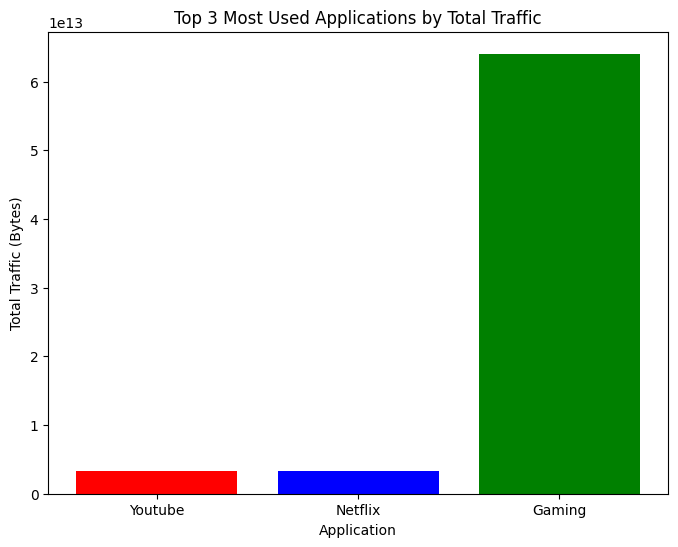

In [32]:
# Ploting the top 3 most used applications using appropriate charts
engagements.top3_trafic_app()

In [ ]:
# optimizing value of k use elbow method
engagements.K_Means_cluster()

# Part-3 Experience Analytics

In [ ]:
# The columns value Replaced with the mean of the respective columns. As well, Outliers Treated using the IQR method by capping 
# values within a reasonable range.

In [35]:
User_Experience = Experience(df)

In [6]:
#df['TCP DL Retrans. Vol (Bytes)'].fillna(df['TCP DL Retrans. Vol (Bytes)'].mean(), inplace=True)
#df['TCP UL Retrans. Vol (Bytes)'].fillna(df['TCP UL Retrans. Vol (Bytes)'].mean(), inplace=True)
columns = df[['TCP DL Retrans. Vol (Bytes)','TCP UL Retrans. Vol (Bytes)']]
#User_Experience.preprocess_column(columns)

In [36]:
# Handle missing values and outliers 
# Missing values are replaced with the mean, and outliers are treated using the IQR method.
class DataCleaner:
    def __init__(self, data):
        self.data = data

    def preprocess_columns(self, columns):
        """
        Preprocess specified columns by handling missing values and outliers.
        """
        for column in columns:
            # Replace missing values with the mean
            self.data[column] = self.data[column].fillna(self.data[column].mean())

            # Treat outliers using the IQR method
            Q1 = self.data[column].quantile(0.25)
            Q3 = self.data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Replace outliers with the mean
            self.data[column] = self.data[column].apply(
                lambda x: self.data[column].mean() if (x < lower_bound or x > upper_bound) else x
            )

# Instantiate the cleaner and preprocess data
data_cleaner = DataCleaner(df)
columns_to_clean = [
    'TCP DL Retrans. Vol (Bytes)', 
    'TCP UL Retrans. Vol (Bytes)', 
    'Avg RTT DL (ms)', 
    'Avg RTT UL (ms)', 
    'Avg Bearer TP UL (kbps)', 
    'Avg Bearer TP DL (kbps)'
]
data_cleaner.preprocess_columns(columns_to_clean)

In [100]:
# Aggregating user total traffic per application
traffic_app = df.groupby('MSISDN/Number').agg({
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum'
})

# Saving the aggregated data to a CSV file
output_file = 'User_Experience.csv'
traffic_app.to_csv(output_file)

Average TCP Retransmission per Handset Type:
                                            Handset Type  \
0                            A-Link Telecom I. Cubot A5   
1                     A-Link Telecom I. Cubot Note Plus   
2                        A-Link Telecom I. Cubot Note S   
3                          A-Link Telecom I. Cubot Nova   
4                         A-Link Telecom I. Cubot Power   
...                                                 ...   
1387  Zte Zte Blade C2 Smartphone Android By Sfr Sta...   
1388                          Zyxel Communicat. Lte7460   
1389                          Zyxel Communicat. Sbg3600   
1390                    Zyxel Communicat. Zyxel Wah7706   
1391                                          undefined   

      Average TCP Retrans. (Bytes)  
0                          1926164  
1                           464270  
2                          5444096  
3                           231016  
4                           166995  
...                    

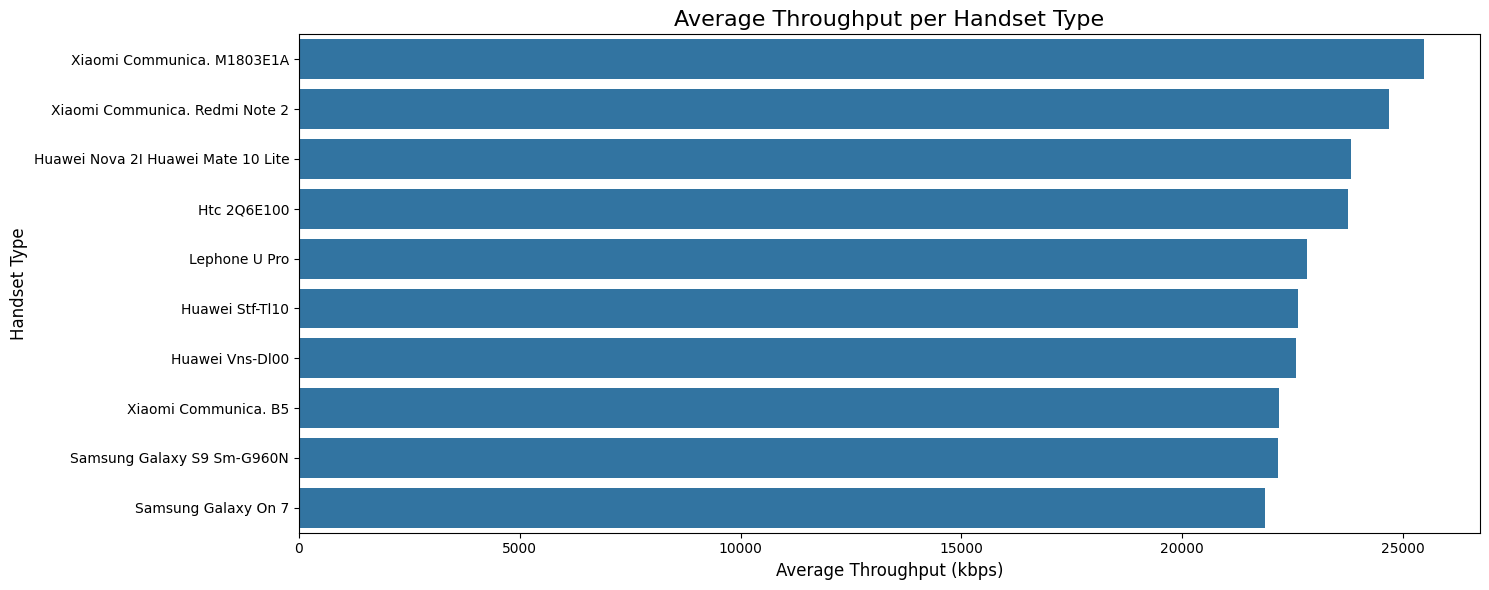

In [37]:
# Compute Average TCP Retransmission
def average_tcp_retransmission(data):
    data['Average TCP Retrans. (Bytes)'] = (data['TCP DL Retrans. Vol (Bytes)'] + data['TCP UL Retrans. Vol (Bytes)']) / 2
    return data.groupby('Handset Type')['Average TCP Retrans. (Bytes)'].mean().reset_index()

tcp_retransmission = average_tcp_retransmission(df)
print("Average TCP Retransmission per Handset Type:\n", tcp_retransmission)

# Compute Average RTT
def average_rtt(data):
    data['Average RTT (ms)'] = (data['Avg RTT DL (ms)'] + data['Avg RTT UL (ms)']) / 2
    return data.groupby('Handset Type')['Average RTT (ms)'].mean().reset_index()

rtt = average_rtt(df)
print("Average RTT per Handset Type:\n", rtt)

# Compute Average Throughput
def average_throughput(data):
    data['Average Throughput (kbps)'] = (
        data['Avg Bearer TP DL (kbps)'] + data['Avg Bearer TP UL (kbps)']
    ) / 2
    return data.groupby('Handset Type')['Average Throughput (kbps)'].mean().reset_index()

throughput = average_throughput(df)
print("Average Throughput per Handset Type:\n", throughput)
# Filter top 10 handset types by average throughput
#top_10_handsets = throughput.sort_values(by='Average Throughput (kbps)', ascending=False).head(10)


# Plot distribution of average throughput per handset type
plt.figure(figsize=(15, 6))
sns.barplot(
    x='Average Throughput (kbps)', 
    y='Handset Type', 
    data=throughput.sort_values(by='Average Throughput (kbps)', ascending=False).head(10)
)
plt.title('Average Throughput per Handset Type', fontsize=16)
plt.xlabel('Average Throughput (kbps)', fontsize=12)
plt.ylabel('Handset Type', fontsize=12)
plt.tight_layout()
plt.show()


## Compute & list 10 of the top, bottom, and most frequent:

In [42]:
class DataAnalysis:
    def __init__(self, data):
        self.data = data

    def preprocess_columns(self, columns):
        """
        Preprocess specified columns by handling missing values and outliers.
        Missing values are replaced with the mean, and outliers are treated using the IQR method.
        """
        for column in columns:
            # Replace missing values with the mean
            self.data[column] = self.data[column].fillna(self.data[column].mean())

            # Treat outliers using the IQR method
            Q1 = self.data[column].quantile(0.25)
            Q3 = self.data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Replace outliers with the mean
            self.data[column] = self.data[column].apply(
                lambda x: self.data[column].mean() if (x < lower_bound or x > upper_bound) else x
            )
    def compute_top_bottom_frequent(self, column):
            """
            Compute and list 10 of the top, bottom, and most frequent values for a specified column.
            """
            top_10 = self.data[column].nlargest(10)
            bottom_10 = self.data[column].nsmallest(10)
            most_frequent = self.data[column].value_counts().head(10)

            return top_10, bottom_10, most_frequent

    def compute_average_throughput_per_handset(self):
        """
        Compute the average throughput per handset type and return the sorted DataFrame.
        """
        throughput = self.data.groupby('Handset Type')['Avg Bearer TP UL (kbps)'].mean().reset_index()
        throughput = throughput.rename(columns={'Avg Bearer TP UL (kbps)': 'Average Throughput (kbps)'})
        return throughput.sort_values(by='Average Throughput (kbps)', ascending=False)

    def plot_throughput_distribution(self, throughput, top_n=10):
        """
        Plot the distribution of average throughput for the top N handset types.
        """
        top_handsets = throughput.head(top_n)
        plt.figure(figsize=(15, 6))
        sns.barplot(
            x='Average Throughput (kbps)', 
            y='Handset Type', 
            data=top_handsets
        )
        plt.title(f'Top {top_n} Handset Types by Average Throughput', fontsize=16)
        plt.xlabel('Average Throughput (kbps)', fontsize=12)
        plt.ylabel('Handset Type', fontsize=12)
        plt.tight_layout()
        plt.show()

# Instantiate the DataAnalysis class
analysis = DataAnalysis(df)

# Preprocess columns
columns_to_clean = [
    'TCP DL Retrans. Vol (Bytes)', 
    'TCP UL Retrans. Vol (Bytes)', 
    'Avg RTT DL (ms)', 
    'Avg RTT UL (ms)', 
    'Avg Bearer TP DL (kbps)', 
    'Avg Bearer TP UL (kbps)'
    ]
analysis.preprocess_columns(columns_to_clean)

analysis.to_csv('User_experience.csv')


### Most Frequent TCP values in the dataset

In [43]:
# Compute and list top, bottom, and most frequent TCP values
top_tcp, bottom_tcp, most_frequent_tcp = analysis.compute_top_bottom_frequent('TCP DL Retrans. Vol (Bytes)')
print("Top 10 TCP values:")
print(top_tcp)
print("\nBottom 10 TCP values:")
print(bottom_tcp)
print("\nMost frequent TCP values:")
print(most_frequent_tcp)

Top 10 TCP values:
99827    7339529
141435   7339008
117135   7338915
59274    7333400
139372   7333338
16265    7332968
116963   7330721
89889    7327765
140883   7325098
80835    7324923
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Bottom 10 TCP values:
59717    2
125094   2
2850     4
39610    4
52488    4
60376    4
60426    4
75093    4
100314   4
143429   4
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Most frequent TCP values:
TCP DL Retrans. Vol (Bytes)
3768308    87821
3356673    10456
1330         427
2660         214
38           199
92           189
1318         155
543          132
3990         111
76           105
Name: count, dtype: int64


### Most Frequent RTT values in the dataset

In [44]:
# Compute and list top, bottom, and most frequent RTT values
top_rtt, bottom_rtt, most_frequent_rtt = analysis.compute_top_bottom_frequent('Avg RTT DL (ms)')
print("\nTop 10 RTT values:")
print(top_rtt)
print("\nBottom 10 RTT values:")
print(bottom_rtt)
print("\nMost frequent RTT values:")
print(most_frequent_rtt)


Top 10 RTT values:
727    122
895    122
1028   122
1478   122
1742   122
2984   122
4004   122
5196   122
6004   122
6074   122
Name: Avg RTT DL (ms), dtype: float64

Bottom 10 RTT values:
42612    0
52225    0
60152    0
61152    0
61345    0
103328   0
124544   0
142526   0
143878   0
71739    2
Name: Avg RTT DL (ms), dtype: float64

Most frequent RTT values:
Avg RTT DL (ms)
70    28270
99    14177
28     3550
27     3374
34     3283
35     2884
37     2708
36     2640
38     2542
29     2495
Name: count, dtype: int64


### Most Frequent Throughput values in the dataset

In [45]:
# Compute and list top, bottom, and most frequent Throughput values
top_throughput, bottom_throughput, most_frequent_throughput = analysis.compute_top_bottom_frequent('Avg Bearer TP DL (kbps)')
print("\nTop 10 Throughput values:")
print(top_throughput)
print("\nBottom 10 Throughput values:")
print(bottom_throughput)
print("\nMost frequent Throughput values:")
print(most_frequent_throughput)


Top 10 Throughput values:
138692   21685
13887    21684
66278    21684
45811    21683
13912    21681
21635    21681
40624    21681
2524     21680
85303    21679
147012   21679
Name: Avg Bearer TP DL (kbps), dtype: float64

Bottom 10 Throughput values:
13     0
149    0
364    0
546    0
618    0
679    0
756    0
809    0
893    0
1185   0
Name: Avg Bearer TP DL (kbps), dtype: float64

Most frequent Throughput values:
Avg Bearer TP DL (kbps)
13314    13106
7956     11292
5466     10841
23        7322
43        4348
44        4184
6         3936
22        2866
48        2777
63        2756
Name: count, dtype: int64


### Compute & report:
The distribution of the average throughput per handset type 

                          Handset Type  Average Throughput (kbps)
705                  Nokia 1661-2 1661                       2701
273                        Htc 2Q6E100                       2682
551     Lenovo Moto X Style Indr001145                       2555
455               Huawei Y6 Prime 2018                       2536
1160        Spa Condor Elect. Plume L2                       2532
...                                ...                        ...
1249                           Wct Uno                          0
235   Group Acquisitio. Fly Evo Chic 4                          0
276            Htc Desire 10 Lifestyle                          0
801   Quectel Wireless. Quectel Ec25-E                          0
800   Quectel Wireless. Quectel Ec21-E                          0

[1392 rows x 2 columns]


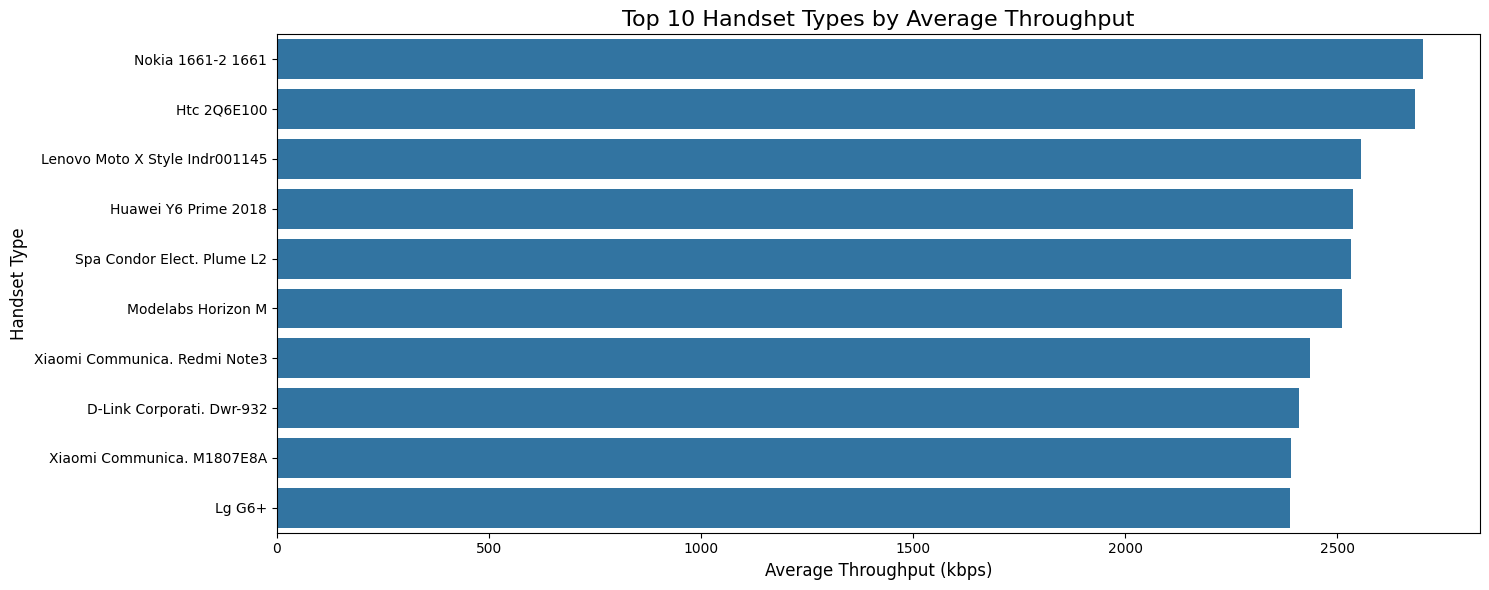

In [47]:
# Compute the distribution of average throughput per handset type
throughput_distribution = analysis.compute_average_throughput_per_handset()
print(throughput_distribution)
# Plot the top 10 handset types by average throughput
analysis.plot_throughput_distribution(throughput_distribution, top_n=10)

# Satisfaction Analysis
Assuming that the satisfaction of a user is dependent on user engagement and experience

In [16]:
df_engagement = None
df_exprience = None
df_satisfaction = None
# Initialize the Db_Connection class
db = Db_Connection()
df = None
try:
    # Call the read_data method for table name
    df_engagement = db.read_data("User_Engagement")
    df_exprience = db.read_data("User_Experience")
    df_satisfaction = db.read_data("user_satisfaction")

except Exception as e:
    # Catch any exceptions and print an error message
    print(f"Error occurred: {e}")

finally:
    # Close the database connection (even if an error occurred)
    db.close_connection()

Database connection initialized successfully!
Database connection closed.


In [48]:
df_engagement = None
df_exprience = None
# Initialize the Db_Connection class
df = None
try:
    # Call the read_data method for table name
    df_engagement = engagements.total_trafic_app()
    df_exprience = throughput_distribution()

except Exception as e:
    # Catch any exceptions and print an error message
    print(f"Error occurred: {e}")

finally:
    # Close the database connection (even if an error occurred)
    print("Data Loaded successfully")


Error occurred: 'DataFrame' object is not callable
Data Loaded successfully


In [ ]:
# Create an instance of the analysis class
analysis = UserSatisfaction()

# Call the method with the DataFrames
results = analysis.satisfaction_computing(df_engagement, df_exprience)

# Display the results
results

### Top satisfied customers based on engagement score & exprience score.

In [53]:
# Call the calculate_top_satisfaction method with the results
Top_satisfied_customers = analysis.calculate_top_satisfaction(results)
# Print the results
print("Top 10 Most Satisfied Customers Based on Satisfaction Score")
Top_satisfied_customers.head(10)

Top 10 Most Satisfied Customers Based on Satisfaction Score


### Build a regression model to predict the satisfaction score of a customer

In [ ]:
# Train a regression model using the results
predictions_df = analysis.train_regression_model(results)
predictions_df

### Use k-means (k=2) on the engagement & the experience score. 

In [ ]:
# Call the perform_kmeans_clustering method with the results
cluster = analysis.perform_kmeans_clustering(results)
cluster

### Aggregating the average satisfaction & experience score per cluster

In [59]:
# Aggregate the average satisfaction score and experience score per cluster
aggregated_cluster = results.groupby('Cluster')[['Satisfaction Score', 'Experience Score']].mean()

# Print the results
print("Average Satisfaction and Experience Scores per Cluster:")
aggregated_cluster

Average Satisfaction and Experience Scores per Cluster:


In [60]:
# Initialize the database connection
db = Db_Connection()

# Create a cursor to execute SQL queries from the connection
cursor = db.get_connection().cursor()

# Create table (if it does not exist already)
cursor.execute("""
CREATE TABLE IF NOT EXISTS user_experience (
    MSISDN_Number BIGINT PRIMARY KEY,
    "TCP DL Retrans. Vol (Bytes)" FLOAT,
    "TCP UL Retrans. Vol (Bytes)" FLOAT,
    "Average DL RTT" FLOAT,
    "Average UL RTT" FLOAT,
    "Average DL Throughput" FLOAT,
    "Average UL Throughput" FLOAT,
    "Most Common Handset Type" VARCHAR
)
""")

# Commit changes and close the cursor
db.get_connection().commit()

# Close the cursor and connection
cursor.close()
db.close_connection()

print("Table created successfully!")

Database connection initialized successfully!
Database connection closed.
Table created successfully!
